In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/XAI/

/content/gdrive/MyDrive/XAI


In [ ]:
#from random import shuffle
!pip install folium
import folium
!pip install xgboost==1.0.1
import xgboost as xg
import pickle
import math
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import keras
import random as rn
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F
#from torch_geometric.nn.dense import DenseGCNConv
from keras.layers import Activation, Dense
from numpy import array as narray
from numpy import inf, median
from tensorflow.keras.optimizers import SGD,Adagrad, Adam, RMSprop

import easydict
import os
#import cupy #런타임 gpu 사용시 
import argparse
import dill
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import atan
#런타임gpu사용시 
#from cupy import zeros, full, where, identity, divide, add, array, ndarray, asarray, asnumpy, stack, vstack, subtract, newaxis, multiply, ones, less, minimum, copy, concatenate, exp, repeat, tile, matmul, isnan, sqrt, log, NaN#, nanmean

import time
from queue import Queue
from sklearn.metrics import mean_squared_error
#geopandas
!pip install geopandas
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.7 MB 10 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.1 MB/s 
     |████████████████████████████████| 16.7 MB 51.6 MB/s 
     |████████████████████████████████| 6.3 MB 49.3 MB/s 


In [ ]:
#1차 전처리 
def InfoMatrix(g) :
    adj = np.zeros((g.shape[0], g.shape[0])) # adj 초기화
    for i in range(g.shape[0]) :
        idx = g[g['dst'] == g.at[i, 'src']].index.tolist() #연결이 되어 있으면 idx로 인덱스 정보 추출
        idx.extend(g[g['src'] == g.at[i, 'dst']].index.tolist())
        #print('IDS shape check : ',np.shape(idx))
        adj[i, idx] = 1 # 인접행렬을 생성
    return adj
    
def BaseInfo() : # 데이터 로드
    speed = pickle.load(open('2018_5pclean_tMatrix.pkl', 'rb')) # 속도 데이터 로드
    g = pickle.load(open('Graph_info.pkl', 'rb')).sort_values(by=['str_id']).reset_index(drop = True) # 인접관계 정보 데이터 로드
 
    # End Point 변환
    g.loc[g[g['dst'].isin(['힐튼'])].index,'dst'] = '도동삼거리'
    g.loc[g[g['dst'].isin(['힐튼'])].index,'dist'] = 322
    
    speed.drop(['3201500100'], axis = 1, inplace = True) # 기후 정보가 없는 링크 드랍
    g = g[g['str_id'] != '3201500100'].sort_values(by=['str_id']).reset_index(drop = True)
    g = g.sort_values(by=['str_id']).reset_index(drop = True)

    linklist = g['str_id'].values # 링크 ID 추출
    dist = g['dist'].astype(int).values # 거리 데이터 추출
    
    #adj = InfoMatrix(g) # 인접행렬 adj랑, cost행렬 추출
    dist = np.asarray(dist)
    #speed = np.asarray(speed.values)
    speed = np.asarray(speed.values).astype('float32')
   
    hopadj = pickle.load(open('tg1_hopadj.picle', 'rb'))
    lnewspeed = pickle.load(open('lnewspeed.picle', 'rb')) #local 노드별  scaled 된 속도 데이터 로드
    gnewspeed = pickle.load(open('gnewspeed.picle', 'rb')) #global하게  scaled 된 속도 데이터 로드
    return hopadj, g, speed, lnewspeed, gnewspeed


#hop count 계산 -> BFS알고리즘사용
def bfs(adj, start_node):
  x= len(adj)
  visit=[0]*x
  ch = [0]*x
  q = Queue()
  for s in np.where(adj[start_node]==1)[0]:
    q.put(s)
    visit[s]=1
    ch[s]=1
  while q.qsize()>0 :
    node = q.get()
    for nextN in np.where(adj[node]==1)[0]:
      if nextN != start_node and ch[nextN]==0:
        ch[nextN]=1
        q.put(nextN)
        visit[nextN]=visit[node]+1          
  return visit

def make_hopadj(adj): #hop count matrix 생성
  tg1_hopadj=[]
  for i in range(len(adj)):
    tg1_hopadj.append(bfs(adj, i))

  with open('tg1_hopadj.picle', 'wb') as f:
    pickle.dump(tg1_hopadj, f)

In [ ]:
'''
* fn1 : make_features(hopadj,speed, obj, tg)
dnn input을 만드는 함수로 obj가 test 인지 train인지에 맞추어서 input 생성하는 함수
input :
  hopadj = hop count 정보 
  speed = feature 만들기 위한 데이터 
  obj = list of 'test' OR 'train' index
  tg = target node idx

output :2차원( #train or test , #hop5이내 + 3)
obj의 hours에서 tg의 features

* fn2 : make_output(speed, obj, tg)
지도 학습이기에 ouput값이 필요, dnn의 ouput을 생성하는 함수

* fn3 : make_features_simulation(hopadj,speed, t, tg)
시뮬레이션 시 필요한 input 생성하는 함수
'''
def make_features(hopadj,speed, obj, tg): 
  
  #print(np.shape(hopadj))#(4670, 4670)
  check = True
  input_tg=[]
  for t in (obj): # (실험용) 노드에 대해서
    features=[] #(#hop5노드들 + 시각 + 요일,) 으로 features 표현 : 
    features.append(speed[t][tg].item()) # 해당 노드의 t시간대 속도
    for cnt in range(1,6): #hop count 1~5 까지
      hop_idx =  np.where(np.array(hopadj[tg])==cnt)[0]      
      #print(hop_idx)
      features.extend(speed[t][hop_idx])
    features.append( ( t%24 +1 )/24) #시각
    features.append( ( (t//24)%7 + 1 ) /7 ) #요일
    input_tg.append(features)
  
  if check:
    check=False
    #print('input_tg shape : (pred:  (#train or test , hop5이내 + 3)) vs ',np.shape(input_tg))# 2차원 (#train or test , hop5이내 갯수 + 3(자기자신속도,시각, 요일))

  return input_tg


def make_output(speed, obj, tg): #t시간대의 output --> t+1의 값 
  output_tg = []  
  for t in (obj):
    output_tg.append(speed[t+1][tg]) # 특정 시간 t에서의 전체 노드의 speed
  #print('output_tg shape : (pred:  (#train or test ) vs', np.shape(output_tg )) #(train or test,)
  return output_tg  

def make_features_simulation(hopadj,speed, t, tg): 
  
  feature=[] #(#hop5노드들 + 시각 + 요일,) 으로 features 표현 : 
  feature.append(speed[t][tg].item()) # 해당 노드의 t시간대 속도
 
  for cnt in range(1,6): #hop count 1~5 까지
    hop_idx =  np.where(np.array(hopadj[tg])==cnt)[0]      
    feature.extend(speed[t][hop_idx])
  feature.append( ( t%24 +1 )/24) #시각
  feature.append( ( (t//24)%7 + 1 ) /7 ) #요일
  
  return feature    

In [ ]:
def RMSE(y_test, y_predict): #판단 지표
    return np.sqrt(mean_squared_error(y_test, y_predict))


def MAPE(y_test, y_predict): #판단 지표
    return np.mean(np.abs((y_test-y_predict)/y_test))*100  

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict
   
  from sklearn.metrics import mean_absolute_error
  print("MAE:",mean_absolute_error(oo,ii))

  print("MAPE:",MAPE(oo,ii))
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

In [ ]:
print(model.feature_importances_)

[0.01177813 0.00138053 0.00122445 0.02520182 0.0060013  0.00169077
 0.00311185 0.00209407 0.00426925 0.00211375 0.00238382 0.00247629
 0.00271666 0.00300443 0.00251019 0.0042854  0.00288022 0.00313536
 0.0027603  0.00261679 0.00342113 0.00252076 0.00316265 0.00279551
 0.00349474 0.00989254 0.00291968 0.00231591 0.00283941 0.00232293
 0.00260399 0.00321221 0.00335735 0.00254066 0.00365512 0.00249074
 0.00254513 0.0032377  0.0029246  0.00388879 0.002778   0.00301727
 0.00358861 0.00357645 0.00395755 0.00516836 0.00287037 0.00312719
 0.00301217 0.00344888 0.00325256 0.00385069 0.00382491 0.00355519
 0.00317925 0.00256823 0.00392144 0.0025884  0.00258455 0.00417638
 0.0026726  0.00343923 0.00364053 0.00351915 0.00409196 0.00340274
 0.00253626 0.0031907  0.00395941 0.00556853 0.00393781 0.00236834
 0.0028316  0.00503422 0.01310465 0.00772058 0.00343765 0.00260516
 0.00269679 0.03337785 0.00384888 0.00318666 0.00393368 0.0050715
 0.00437435 0.00309866 0.00365684 0.01533302 0.00338249 0.00354

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
sorted_feature_importance

array([  2,   1,   5,   7,   9,  27,  29,  71,  10,  11,  35,  14,  21,
        66,  33,  36,  97,  55,  58,  57,  30,  77,  19,  60,  78,  12,
        18,  40,  23,  72,  28,  46,  16,  26,  38,  95,  13,  48,  41,
        85,   6,  47,  17,  90,  22,  54,  81,  67,  99,  93,  31,  37,
       102,  50, 101,  94,  32,  88,  65,  20,  98,  76,  61,  49,  24,
        92,  96,  63, 108,  89,  53,  43,  42,  62,  34,  86, 100, 106,
        52,  80,  51,  39,  56,  82,  70,  44,  68,  64,  59,   8,  15,
       103,  84,  73,  83,  45,  69,   4,  91, 104,  75,  25,   0,  74,
        87,   3,  79, 105, 107])

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []

    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.jsonG4640")
    topidx = [3223,3354,3353,3244,2982,469,392,2148,2984,3115]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test'+str(k)+'_'+str(tg)+'.jpg')



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

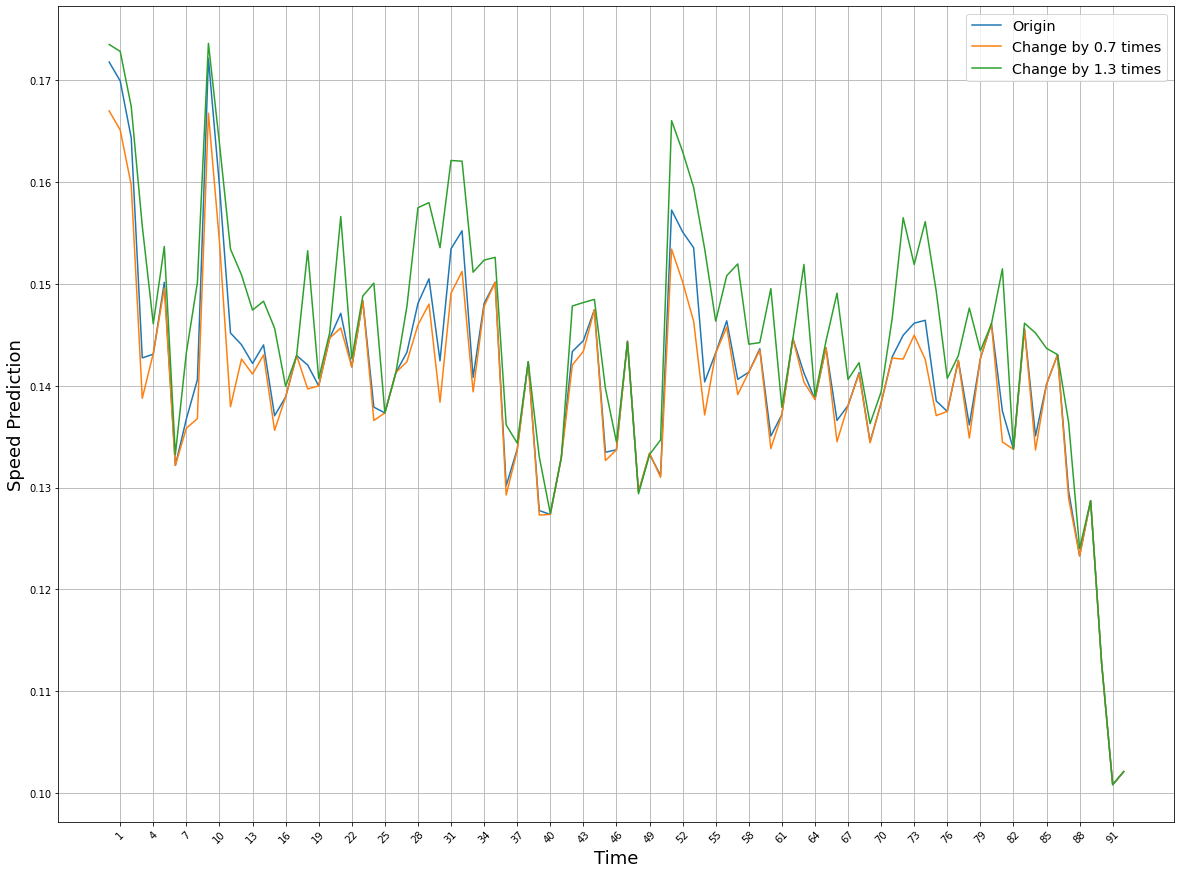

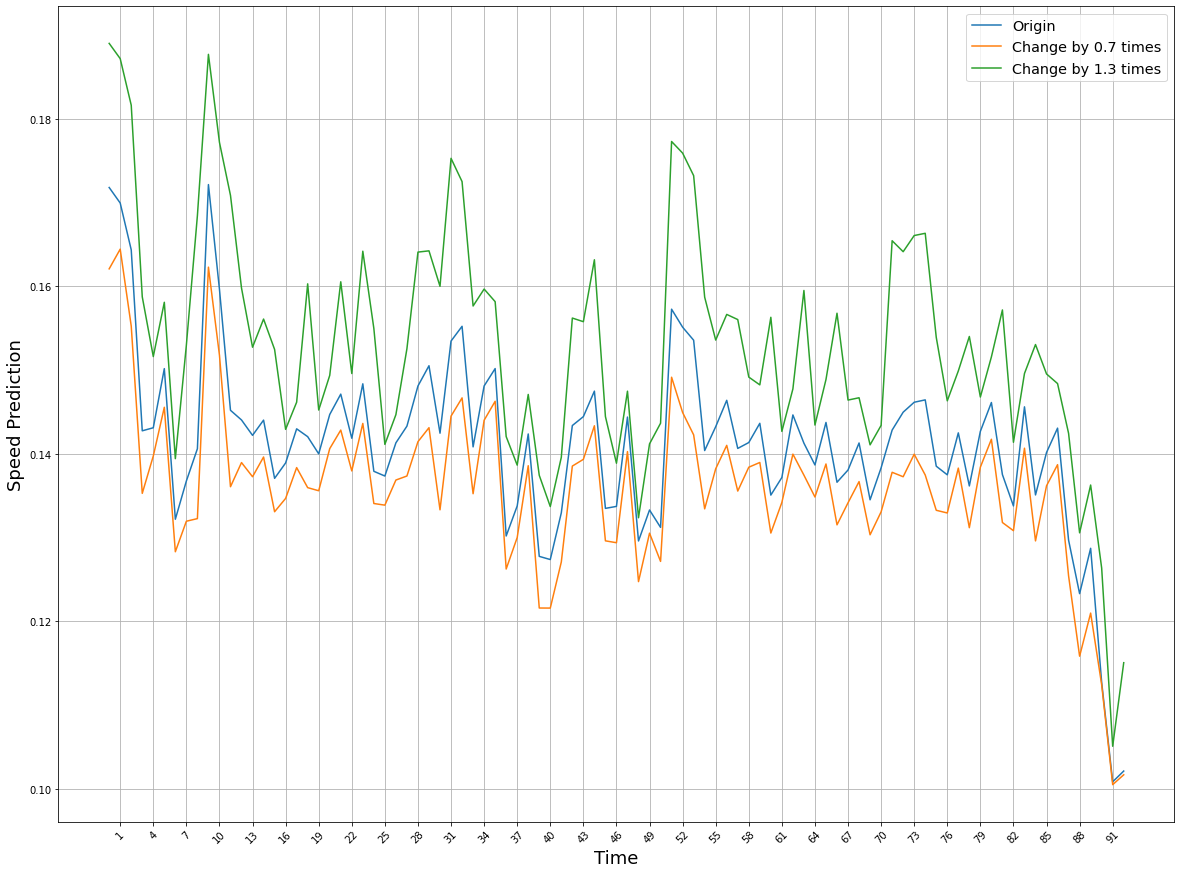

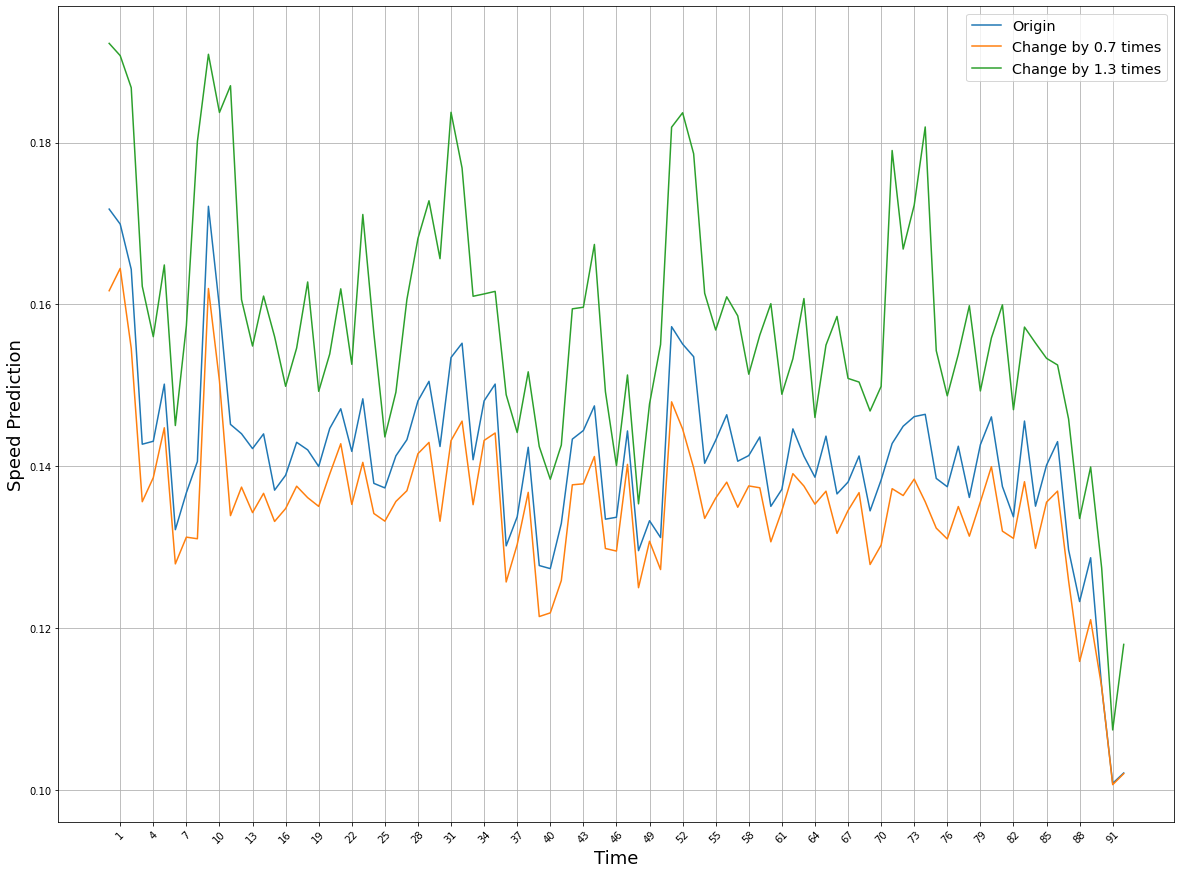

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,3244,2982,392,397,3294,3354,2148,3178,3355]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_rfe'+str(k)+'_'+str(tg)+'.jpg')


In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,3244,2982,392,397,3294,3354,2148,3178,3355]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_rfe'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

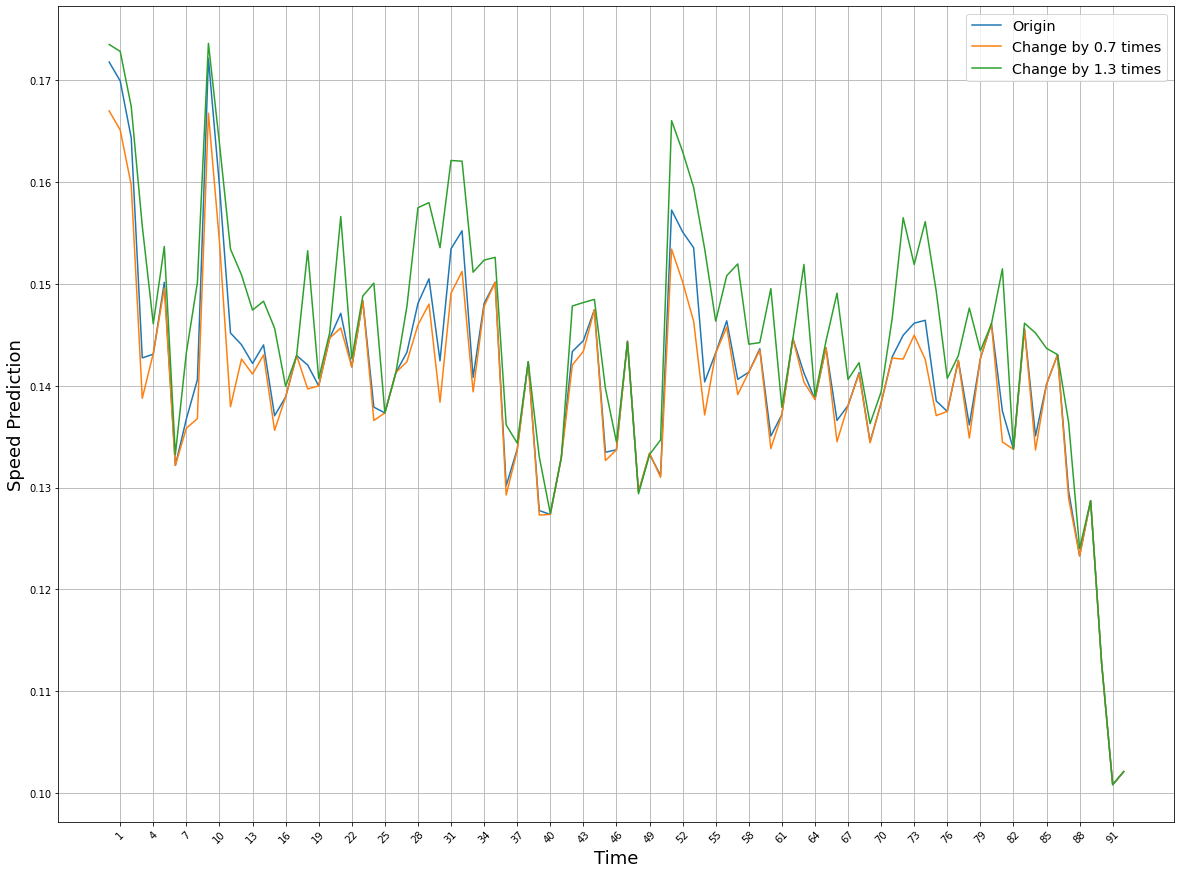

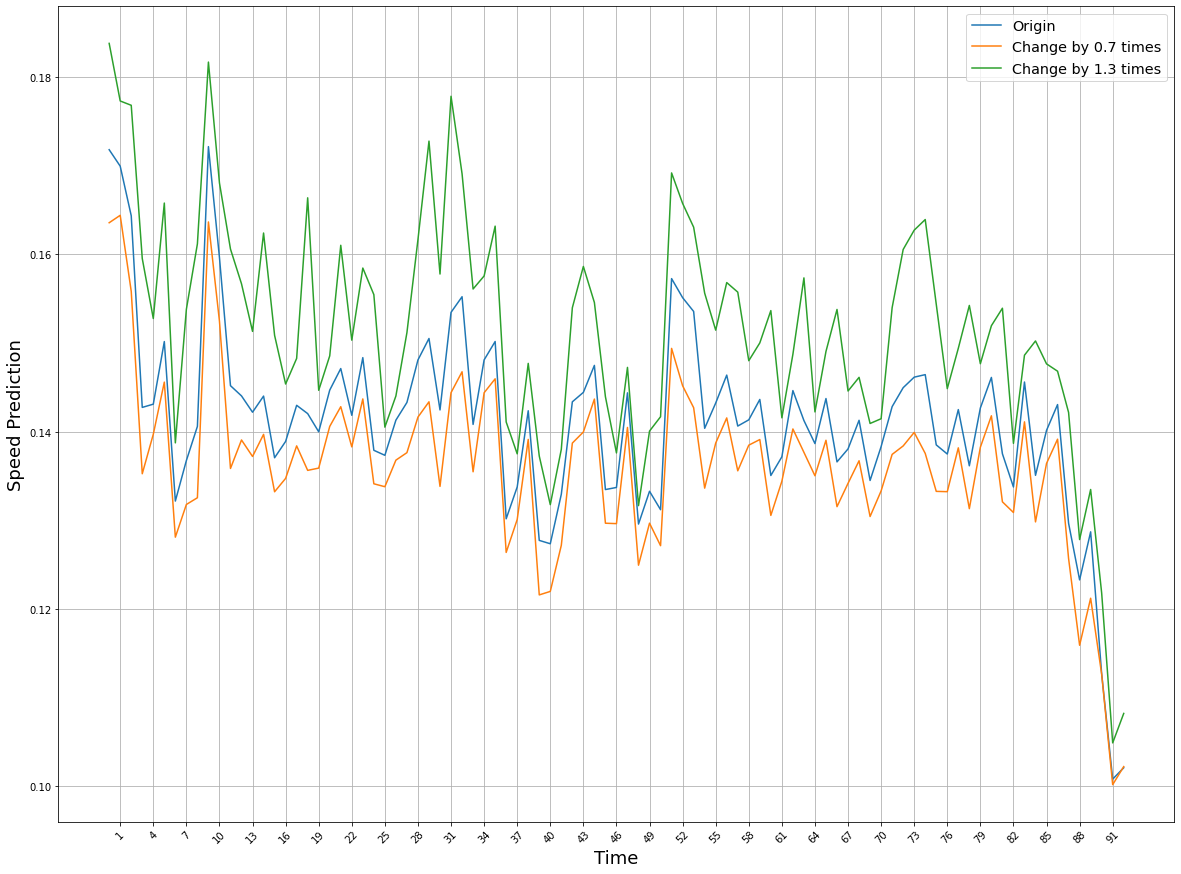

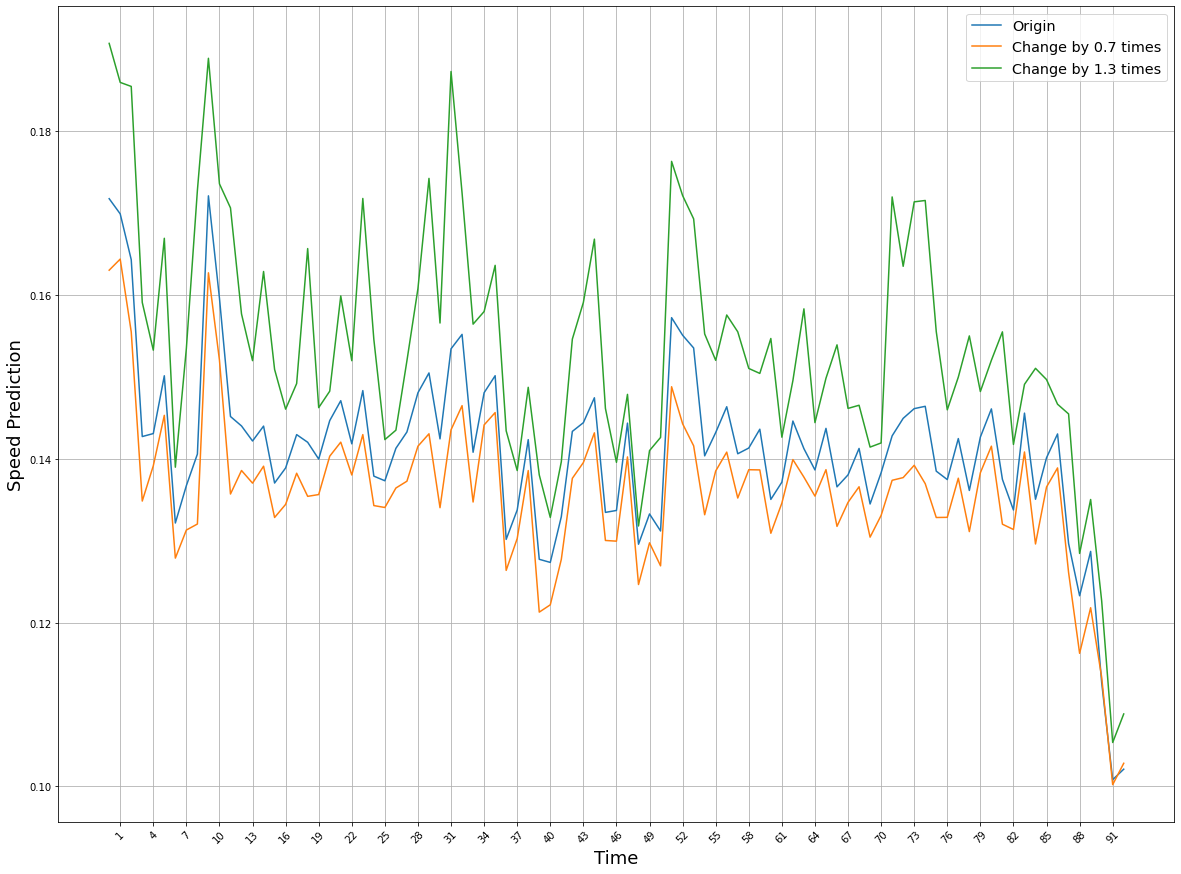

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 



In [ ]:

pd.set_option('display.max_columns', 100)


def day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]

  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.jsonG4640")
    bottomidx = [395,2087,389,3190,3219,2983,3156,3158,2088,3191]
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      bottomk = bottomidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][bottomk] = changespeed05[t][bottomk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
      
      changespeed15 = newspeed.copy()
      changespeed15[t][bottomk] = changespeed15[t][bottomk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18) #increase font size
    plt.ylabel('Speed Prediction',fontsize=18) #increase font size
    #plt.title('Simulate Speed Prediction with Bottom 10')
    
    plt.plot(origin, label = "Origin")  #original speed
    plt.plot(change05, label = "Change by 0.7 times")   #30% Decrease 
    plt.plot(change15, label = "Change by 1.3 times")   #30% Increase

    print('BOTTOM SIMULATION')
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("change07 Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("change13 Mean :  ",np.mean(np.divide(d2,origin) *100))
    
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('simulate_bottom_test_rfe'+str(tg)+'.jpg')    



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

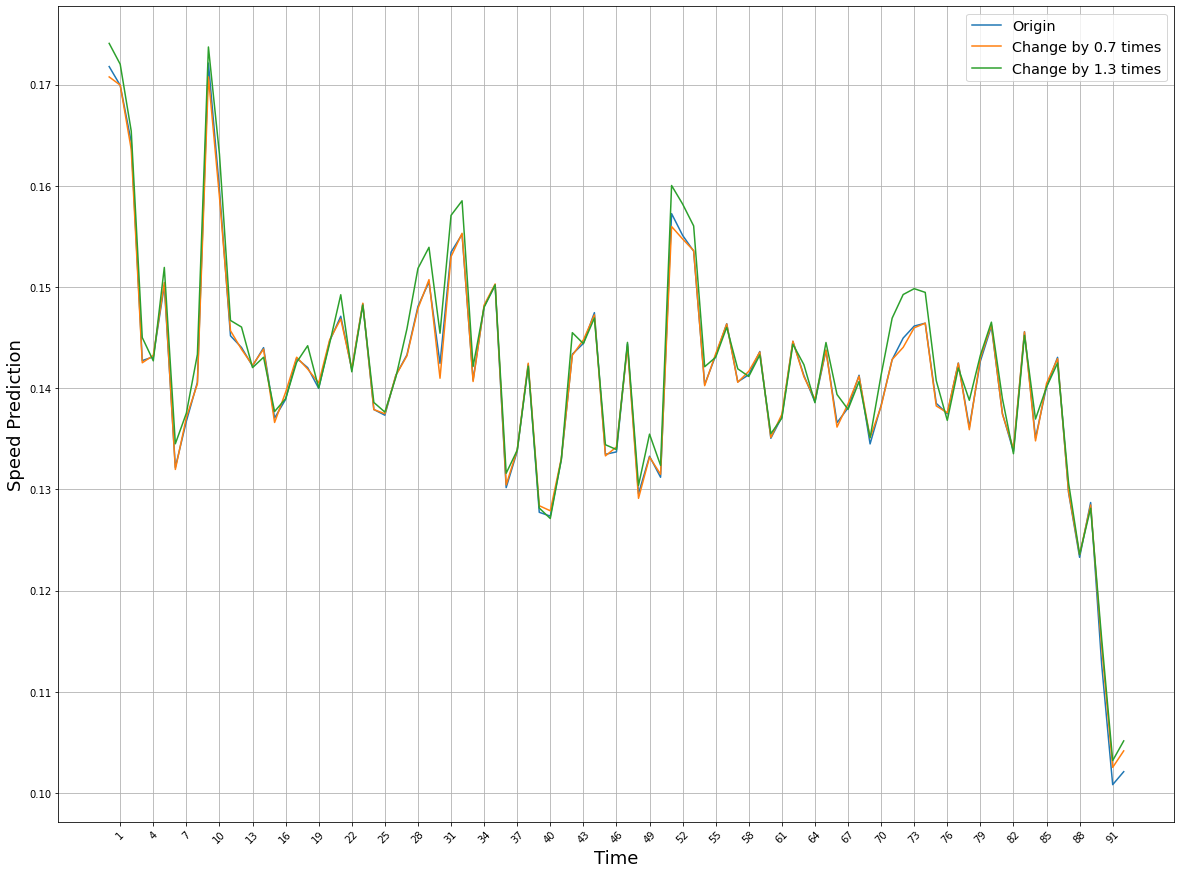

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))


  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  #day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  #day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  #day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 
  print('bottom 10')
  day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,10) #Exp 2) Control bottom10



In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 564 kB 7.8 MB/s 


In [ ]:
model = xg.XGBRegressor()
model.load_model("model_sklearn_xgb.jsonG4640")

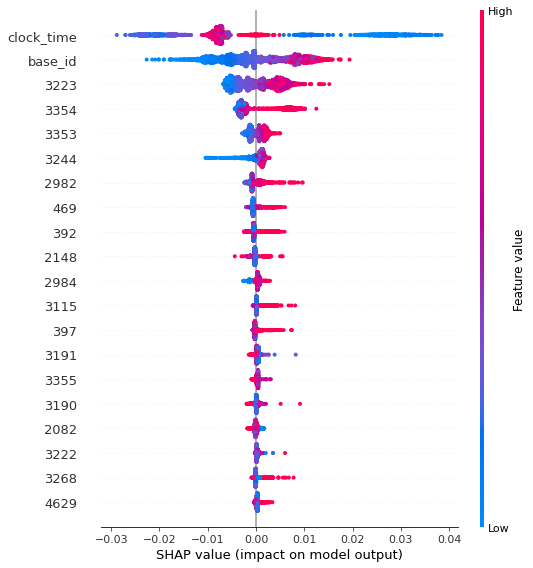

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_test_df)
shap.summary_plot(shap_values, input_test_df)

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,3354,3353,3244,2982,469,392,2148,2984,397]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_shap'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

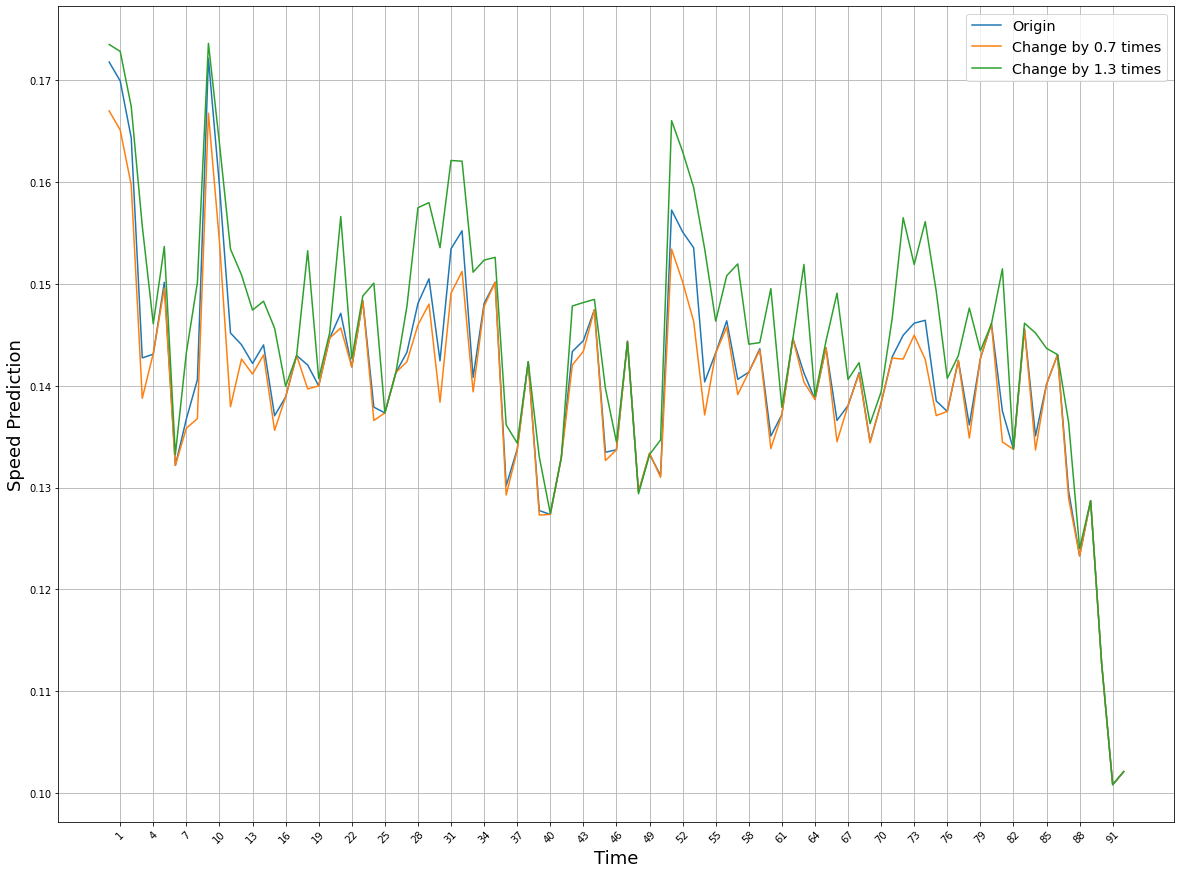

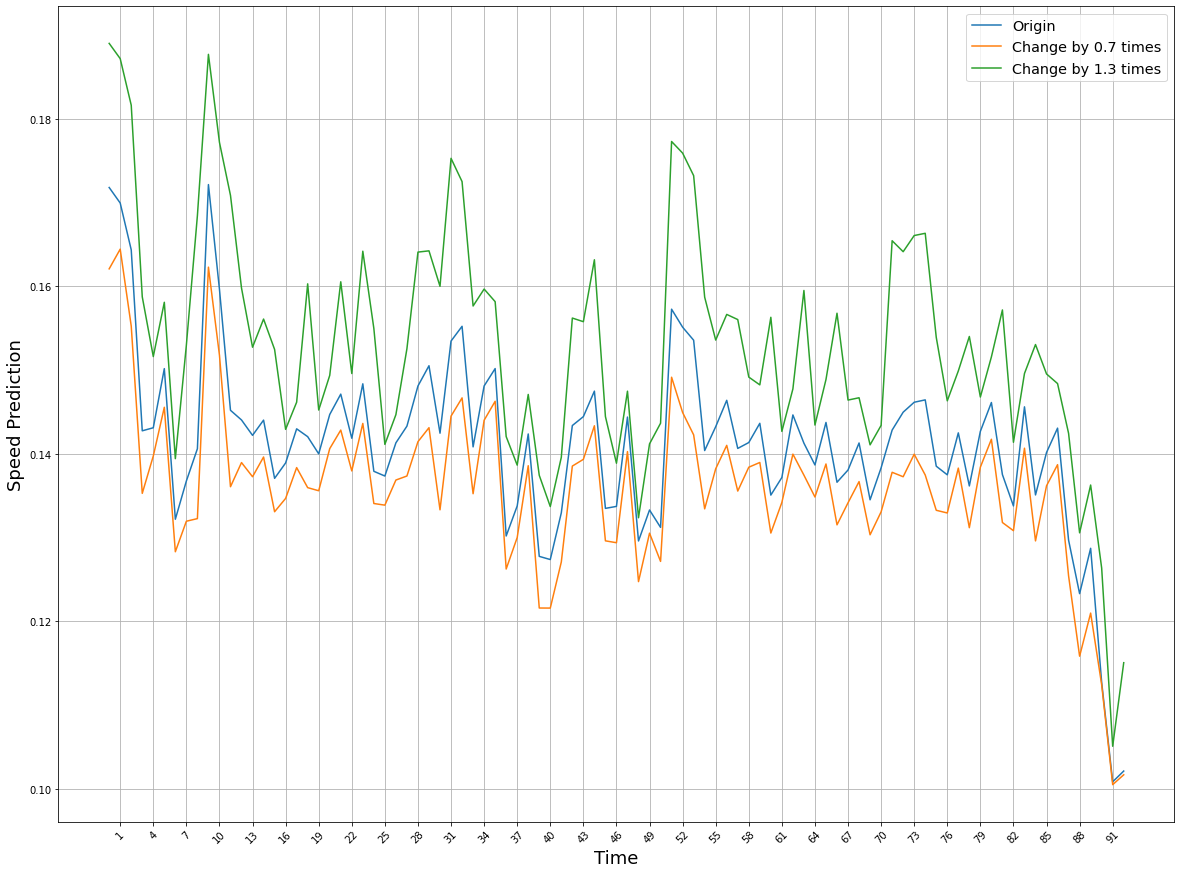

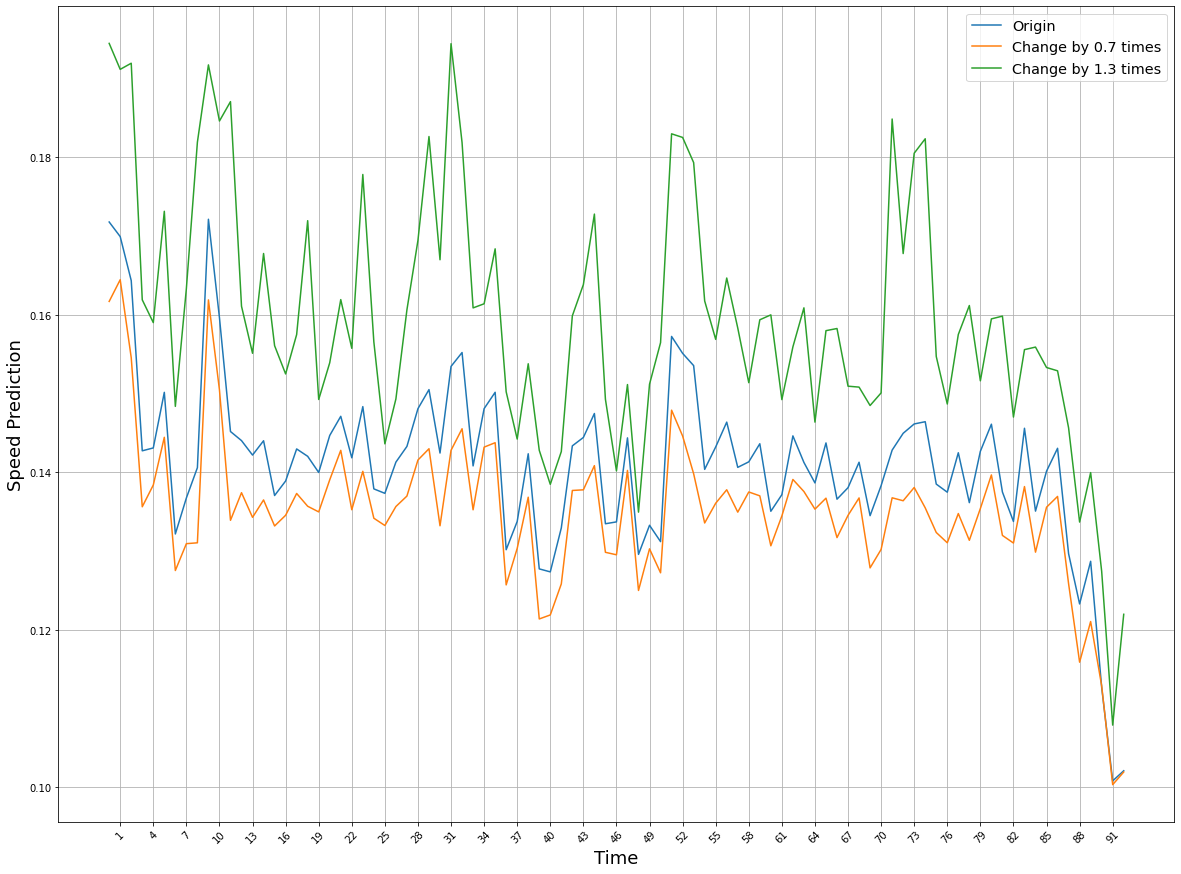

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 



In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'

  ############################################################################################
  #Step2) Generate model for each tg(one base road in tg1idx)
  ##############################################
  start_train = True # ****Control(True vs False)**** #If want to generate new model set True vs Use pre-trained model set False
  state = 0 # ****Control(0 vs 1)**** 0 : only one road in tg1idx  vs 1 : All roads in tg1idx
   
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))

  tg1idx = tg1idx[4:5]
  print('======== Training DNN MODEl START ========')

  for tg in tg1idx: #generate model for each base node
    print('=== Training DNN MODEl Progress ===')
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

    input_d = np.asarray(make_features(hopadj, newspeed, day, tg)).astype('float32')
    output_d = np.asarray(make_output(newspeed, day, tg)).astype('float32')
  
####################################################################
  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  

  input_df = pd.DataFrame(input_d, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_df = pd.DataFrame(output_d, columns = ['(t+1)speed'])

hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
======== Training DNN MODEl START ========
=== Training DNN MODEl Progress ===
** Current : 4640 out of [4640]


In [ ]:
model = xg.XGBRegressor()
model.load_model("model_sklearn_xgb.jsonG4640")

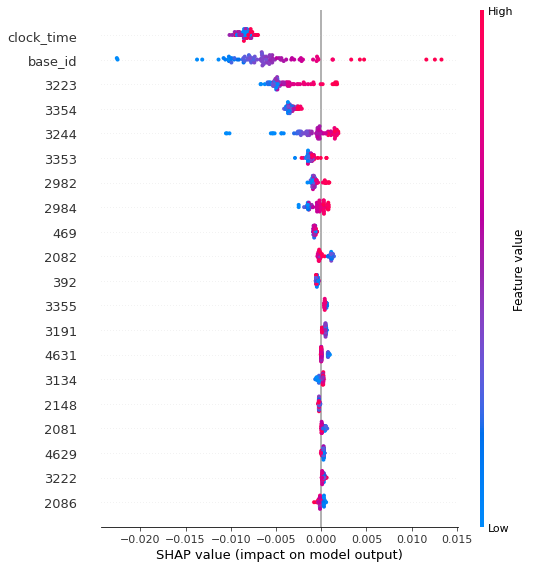

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_df)
shap.summary_plot(shap_values, input_df)

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,3354,3353,3244,2982,2984,469,2082,392,3355]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_shapd'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

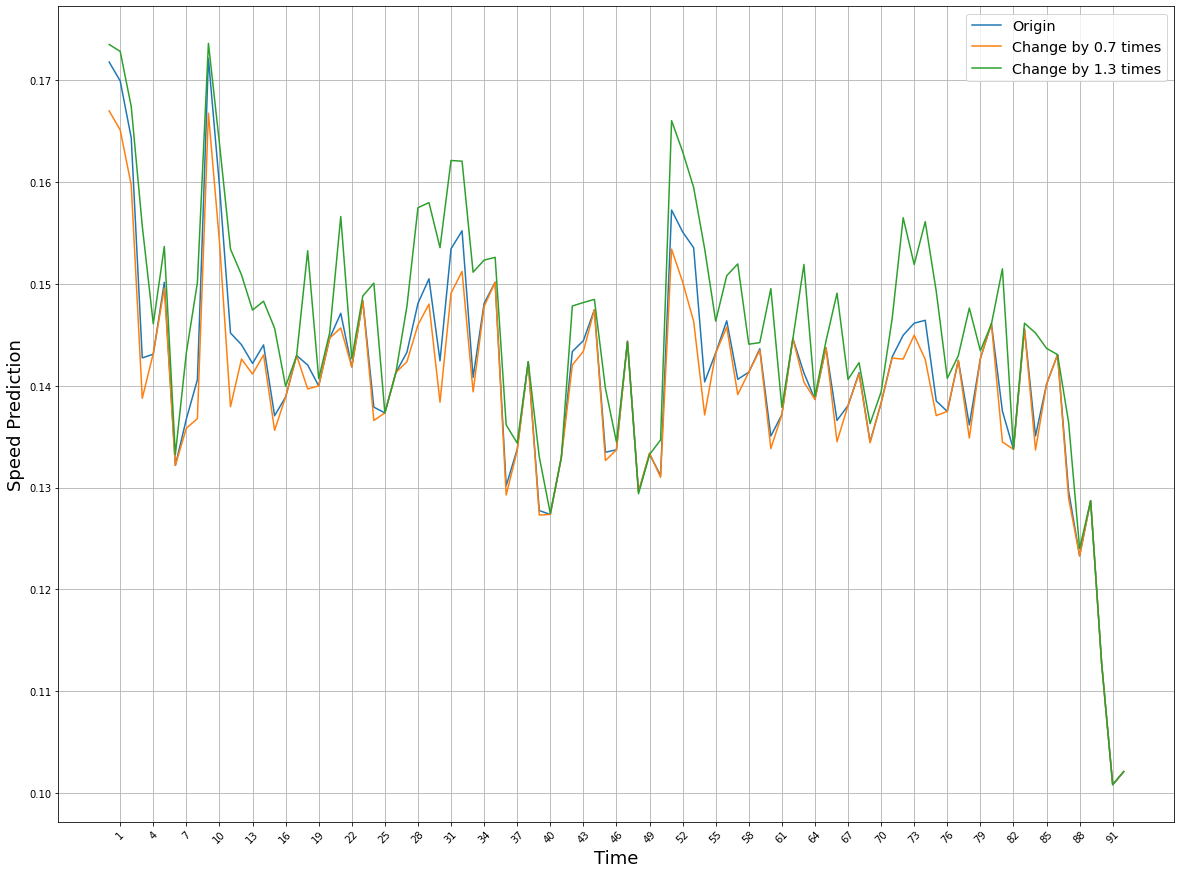

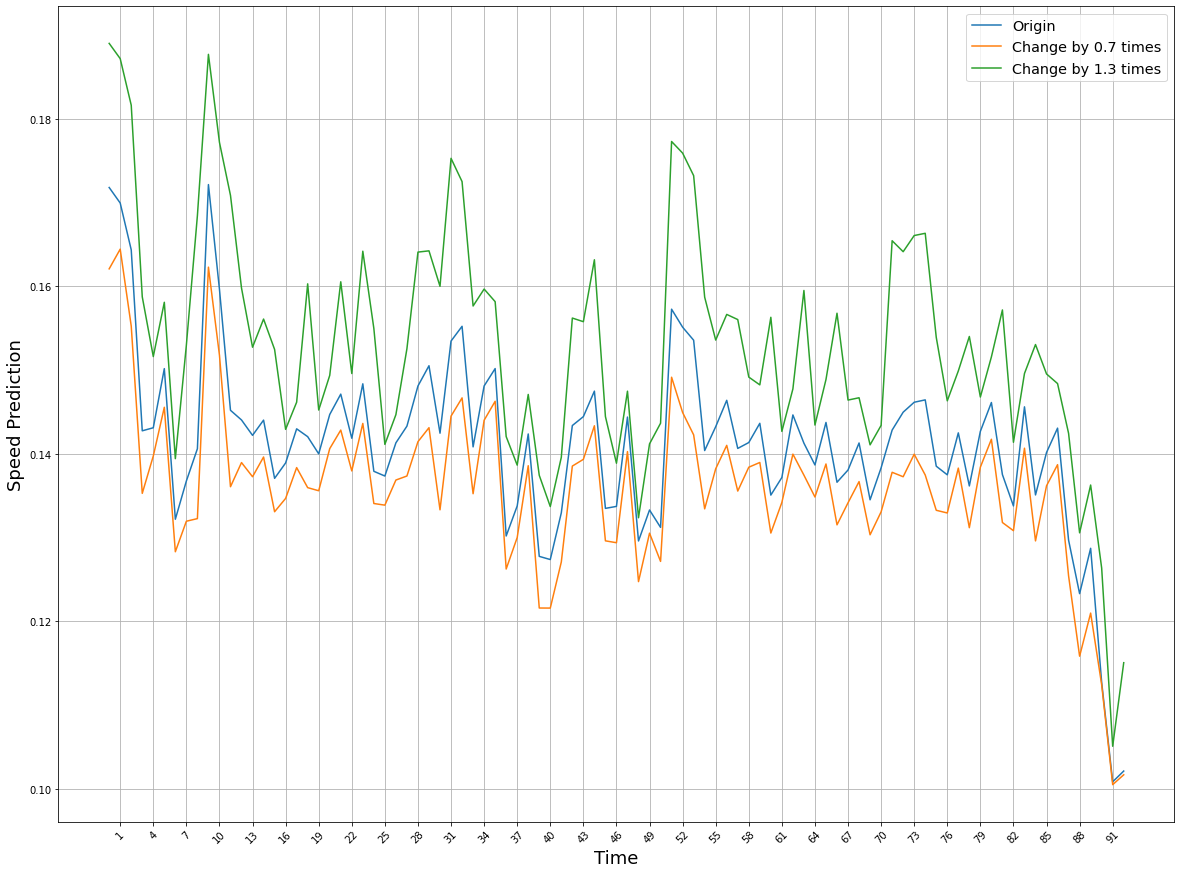

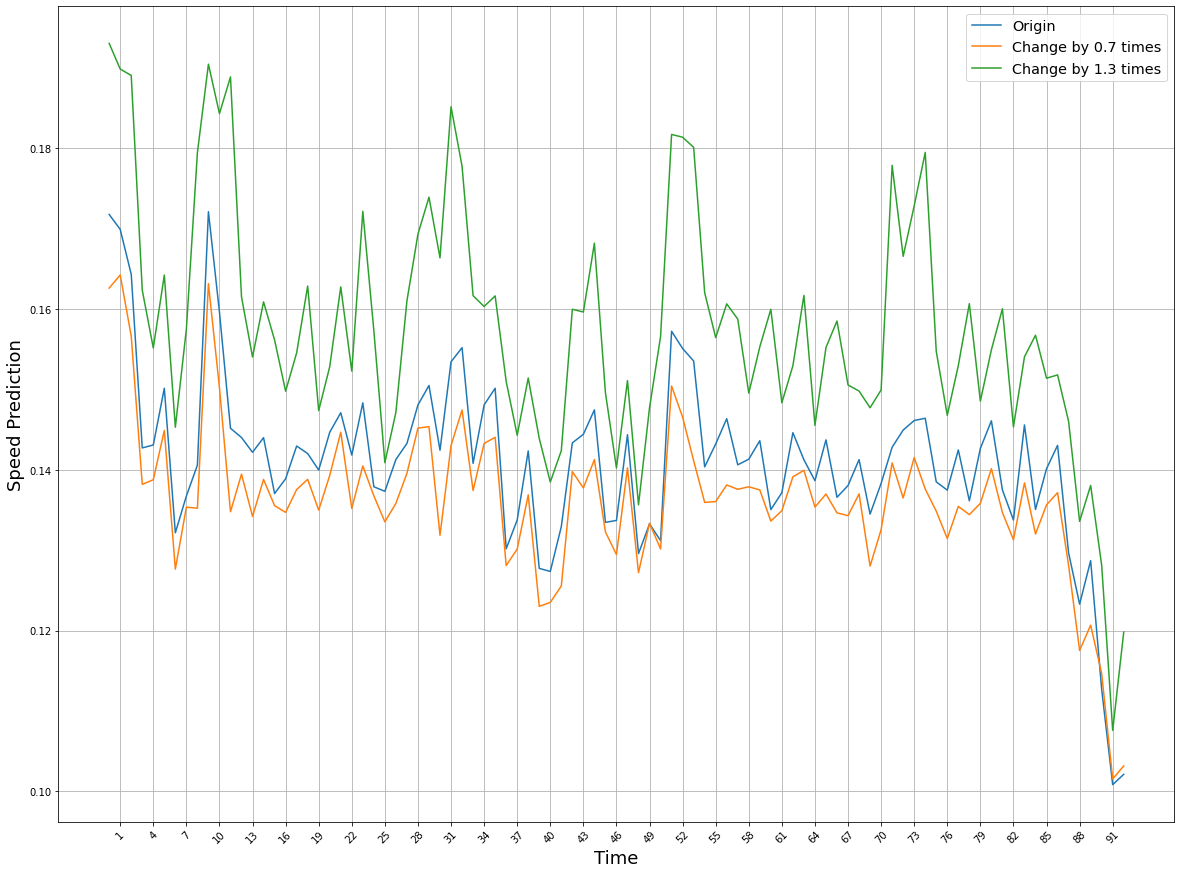

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,3354,3353,3244,4631,2982,2984,469,3295,397]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_lime'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

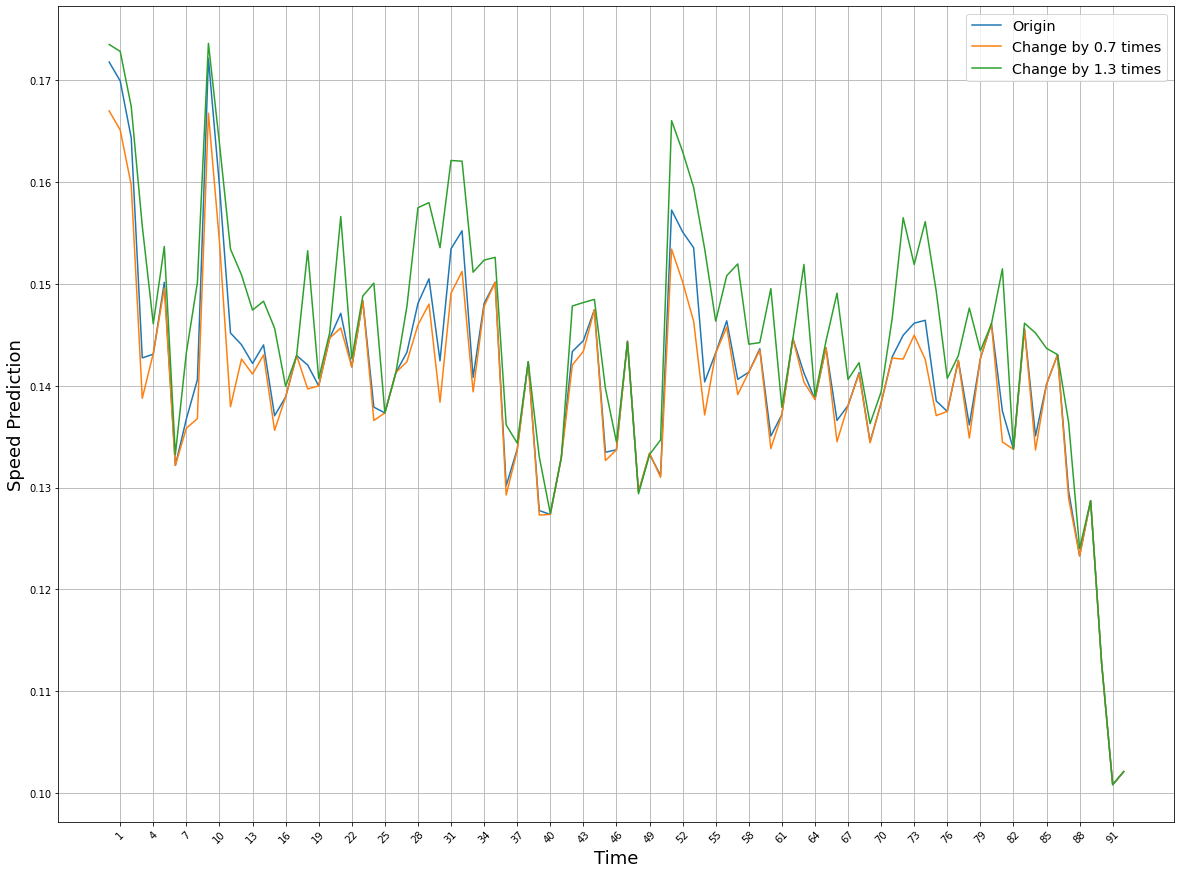

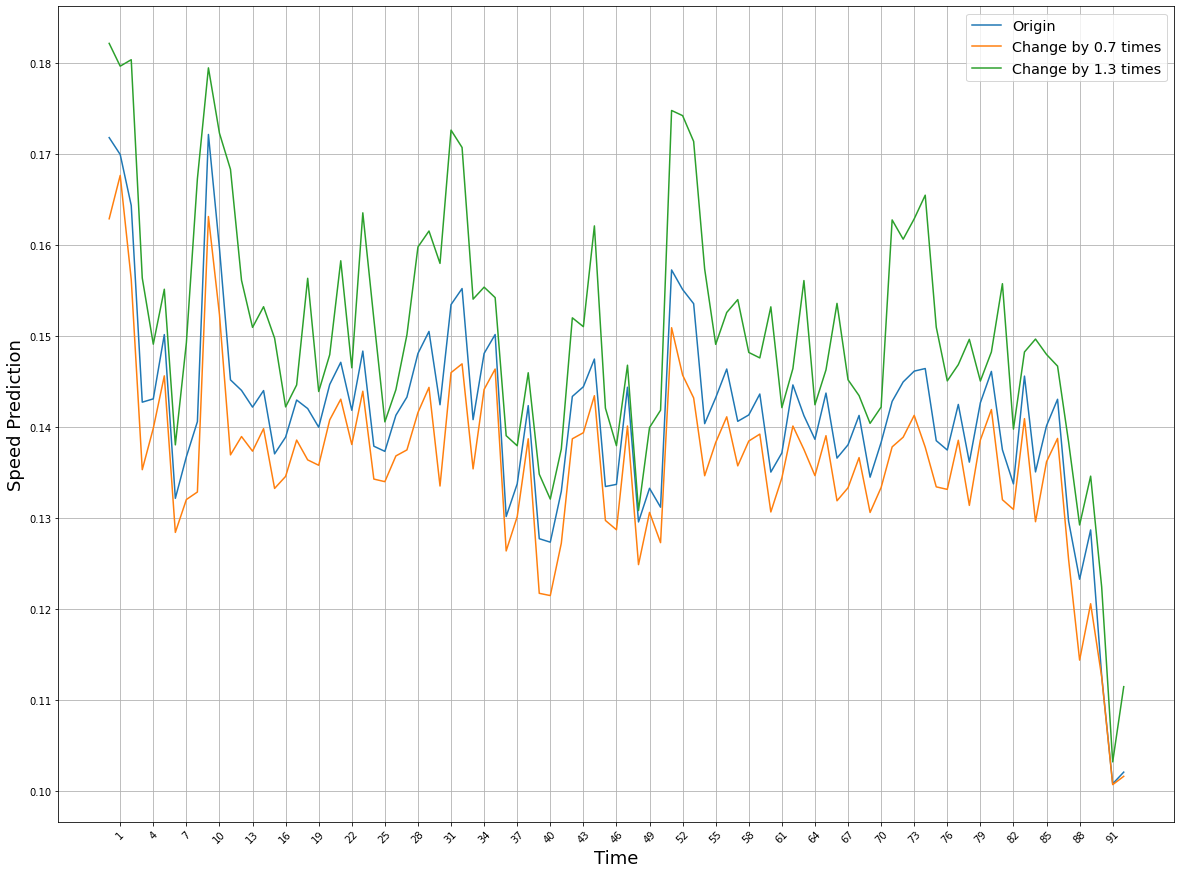

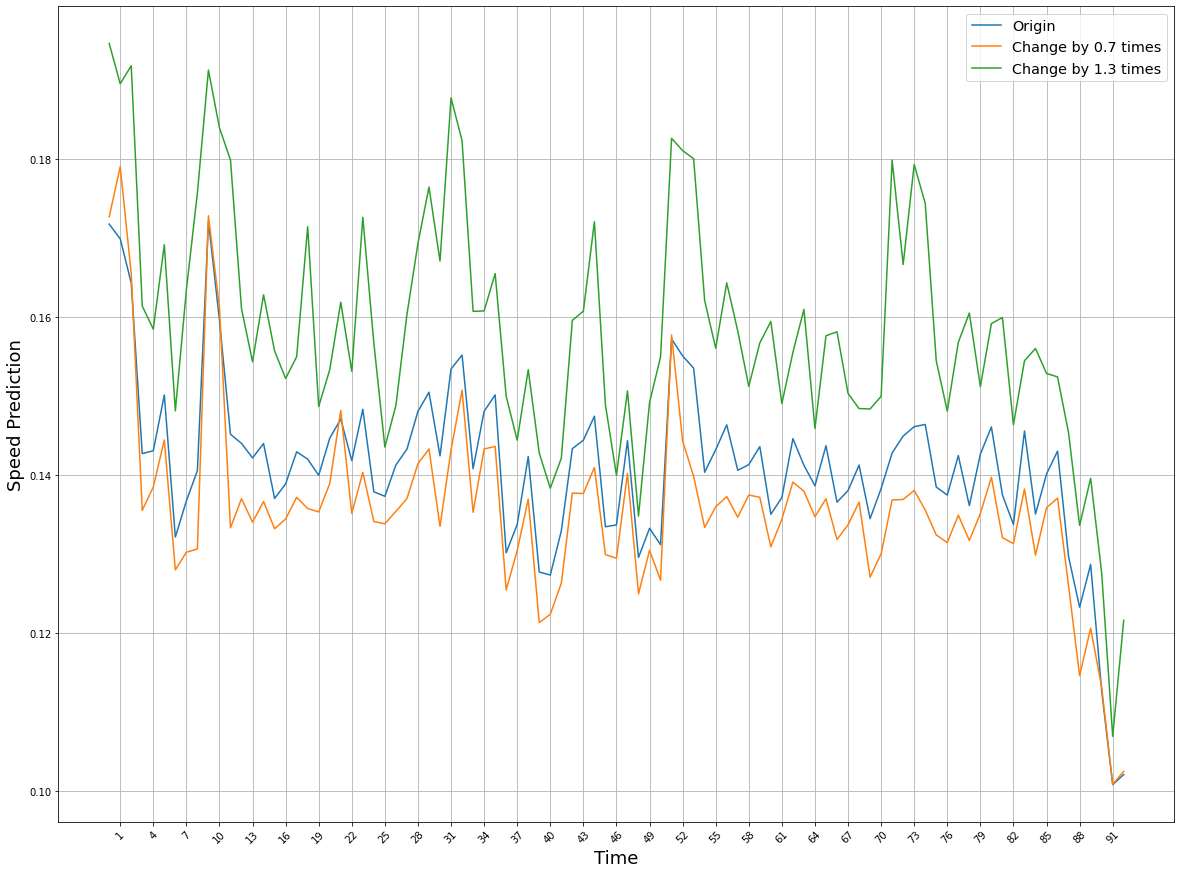

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,3244,2982,392,3354,3231,469,2148,2984,397]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_combined'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

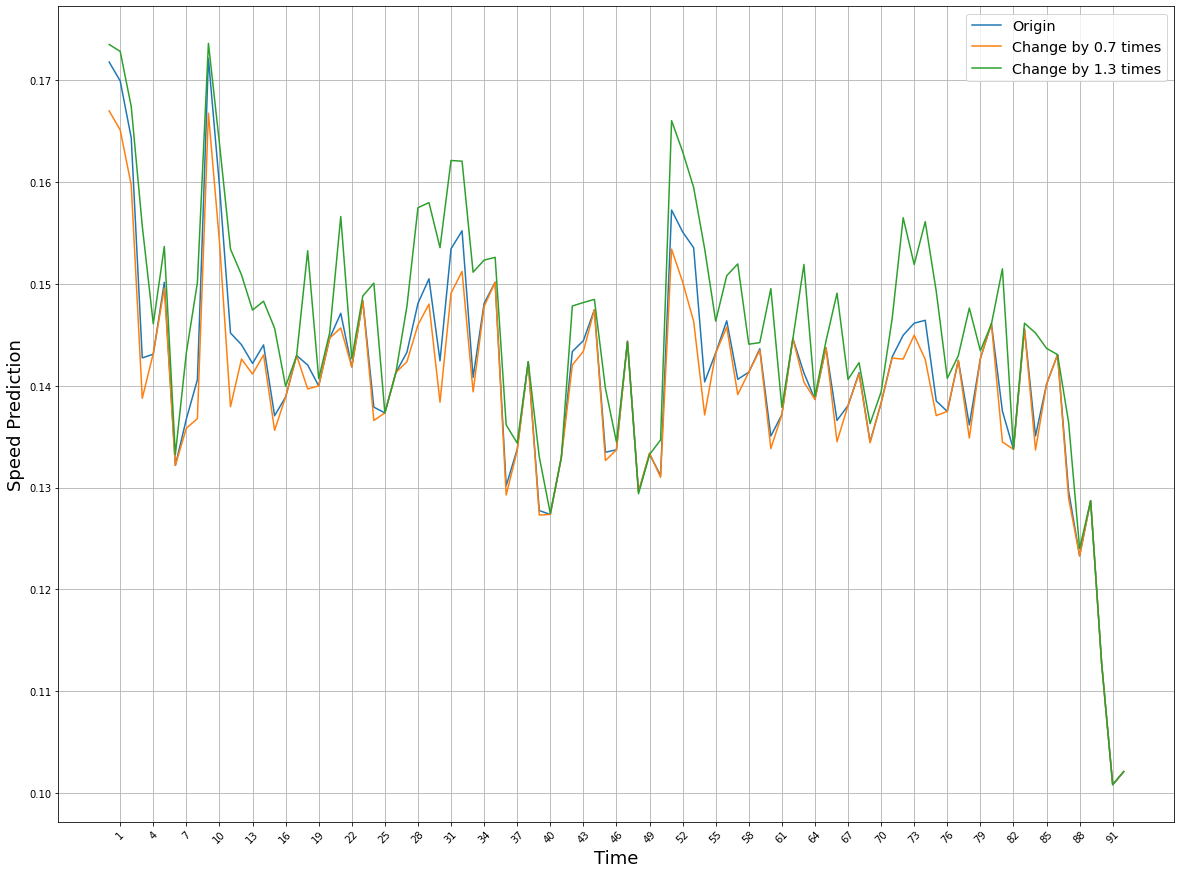

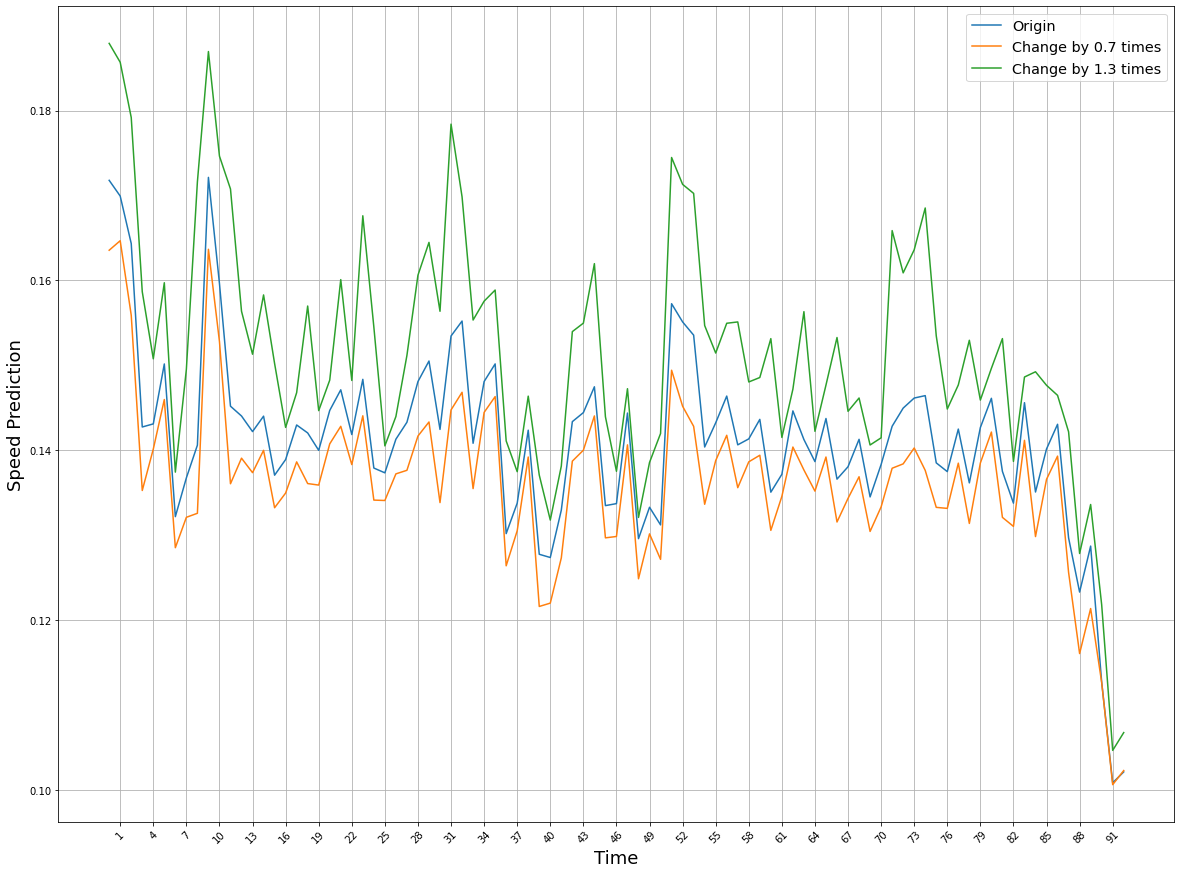

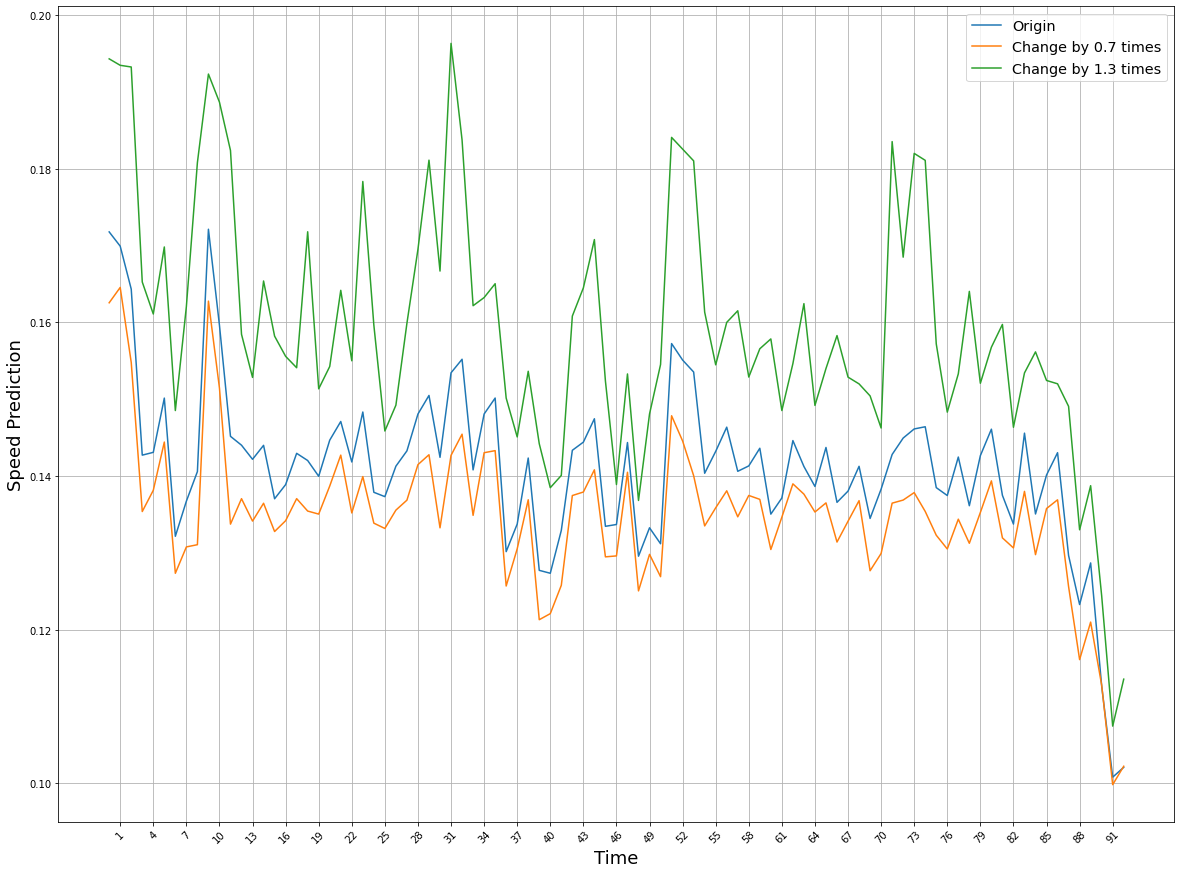

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 



In [ ]:
def RMSE(y_test, y_predict): #판단 지표
    return np.sqrt(mean_squared_error(y_test, y_predict))
'''
def day_exp(dt,hopadj, newspeed, tg1idx, state)
input)  day = 실험해볼 시간대 ex) range(7,11) --> 고민해볼 요소!!
        hopadj
        newspeed
        tgidx = target들의 idx ex) tg1 여의나루의 경우, 6개 index
        state  = 0 : 실험용 vs state = 1: 실제용
output) tg1idx내의 각 tg 실험에 대한 결과값을 dataframe으로 저장 : 파일명 )globals()['df_' + str(tg)]
        dataframe 형식 : pd.DataFrame(columns=['BaseIdx', 'TargetIdx', 'Hop', 'Rate', 'target_src','target_dst','target_road' ]) 
        이때 Rate 가 실험결과 : rate = RMSE(changed, original) * 100 # 바꾸기전 예측 vs hop5 이내 노드 중 특정 targetidx를 바꾼뒤 예측 변화율 
'''
def day_exp(day,hopadj, newspeed, tg1idx, state, road_name,scaled):
  if state ==0: #테스트용
    tg1idx = tg1idx[4:5]  
  check = True
  print("day_exp Check : ",tg1idx)
  for tg in tg1idx:  # tg도로 
    #model = keras.models.load_model("tg1_model_" + scaled+str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    globals()['df_'+scaled+road_name + str(tg)]  = pd.DataFrame(columns=['BaseIdx', 'TargetIdx', 'Hop','Rate07','Rate09', 'Rate11','Rate13','target_src','target_dst','target_road' ])  # 결과 값 저장 dataframe 선언
   
    #각각의 모든 도로가 base가 됨 : base 도로 기준 나머지 변화시켜보기
    print("==============={} Check Start=================".format(tg))
    input_d = np.asarray(make_features(hopadj, newspeed, hour_test, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
    if check:
      check = False
      print('input_d shape : 예상(size(day),hop5이내 노드수) vs ', np.shape(input_d))
      print(input_d)
    original = model.predict(input_d)  # 바꾸기 전 값들로 예측
    real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
 
    hop5idx = []
    for hopcnt in range(1, 6): 
      hopidx = np.where(np.array(hopadj[tg]) == hopcnt)[0]  # base 노드와 hop cnt 인 도로들의 idx         
      hop5idx.extend(hopidx)
    print('{} HOP 5 node # : {}'.format(tg, len(hop5idx)))
   ######################## 
   ## << 마스킹 >>
    for k in range(np.shape(input_d)[1] - 3):# 실제용, 모든 주변 노드 한개씩 바꿔보기
      #마스킹
      #input_d05 = input_d.copy()
      #input_d05[:,k+1]=input_d05[:,k+1]*0.5 #특정 노드를 0.5배 로 마스킹

      input_d07 = input_d.copy()
      input_d07[:,k+1]=input_d07[:,k+1]*0.7 #특정 노드를 0.7배로 마스킹

      input_d09 = input_d.copy()
      input_d09[:,k+1]=input_d09[:,k+1]*0.9 #특정 노드를 0.9으로 마스킹

      input_d11 = input_d.copy()
      input_d11[:,k+1]=input_d11[:,k+1]*1.1 #특정 노드를 1.1으로 마스킹

      input_d13 = input_d.copy()
      input_d13[:,k+1]=input_d13[:,k+1]*1.3 #특정 노드를 1.3으로 마스킹

      changed07 = model.predict(input_d07)  # 0.7배로 바꾼 뒤 예측
      changed09 = model.predict(input_d09)  # 0.9배로 바꾼 뒤 예측
      changed11 = model.predict(input_d11)  # 1.1배로 바꾼 뒤 예측
      changed13 = model.predict(input_d13)  # 1.3배로 바꾼 뒤 예측

      rate07 = RMSE(changed07,original) * 100 # 0.7배로 바꾼 뒤 예측
      rate09 = RMSE(changed09,original) * 100 #0.9배로 바꾼 뒤 예측
      rate11 = RMSE(changed11,original) * 100  # 1.1배로 바꾼 뒤 예측
      rate13 = RMSE(changed13,original) * 100 # 1.3배로 바꾼 뒤 예측
   
      # 데이터프레임 작성 위함 -> 방금 변화시킨 k번째 노드에 대한 데이터 불러오기
      targetidx = hop5idx[k]
      target_info = ginfo.iloc[targetidx][1:4]

      data = [tg, targetidx, hopadj[tg][targetidx], rate07,rate09,rate11,rate13,target_info['src'], target_info['dst'], target_info['road'] ]

      # 데이터 추가해서 원래 데이터프레임에 저장하기
      # 0배 vs original
      globals()['df_' + scaled +road_name+ str(tg)] = globals()['df_' + scaled +road_name+ str(tg)].append(pd.Series(data, index=globals()['df_' + scaled +road_name+ str(tg)].columns), ignore_index=True)
    
    #최종 저장  
    globals()['df_' + scaled +road_name+ str(tg)].to_pickle("df_" + scaled+road_name+str(tg)+".pkl")

  for idx, tg in enumerate(tg1idx):  # tg도로
    #Rate 변화 큰 순으로 sort : dfs_
    #globals()['df_' + road_name+str(tg)] = pd.read_pickle("df_"+road_name+str(tg)+".pkl")
    #print('>> 0.5배 기준 혼잡')
    globals()['dfs07_' + scaled+road_name + str(tg)] = globals()['df_' +scaled+road_name+ str(tg)].sort_values(by=["Rate07"], ascending=[False])
    #print('>> 1.5배 기준 원활')
    globals()['dfs13_' + scaled+road_name + str(tg)] = globals()['df_' +scaled+road_name+ str(tg)].sort_values(by=["Rate13"], ascending=[False]) 
    
    df07 = globals()['dfs07_'+scaled+road_name + str(tg)].copy() #sort된 dataframe 
    df13 = globals()['dfs13_'+scaled+road_name + str(tg)].copy() #sort된 dataframe 

    df07 = df07.reset_index(drop=True)
    df13 = df13.reset_index(drop=True)

    print('>> 0.7 혼잡 TOP => ',df07[:20])
    print('>> 0.7 혼잡Bottom =>',df07[-20:])
  
    print('>> 1.3 원활 TOP => ',df13[:20])
    print('>> 1.3 원활Bottom =>',df13[-20:])




In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  

  tg1idx = tg1.index.tolist() 

  if start_exp == True:  

    
    day_exp(hour_test, hopadj, newspeed, tg1idx,state,road_name, scaled) # Experiment 1)masking method 적용 실험
 



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
day_exp Check :  [4640]
===============4640 Check Start=================
input_d shape : 예상(size(day),hop5이내 노드수) vs  (2880, 109)
[[0.1917     0.2283     0.1865     ... 0.4516     0.04166667 0.5714286 ]
 [0.2155     0.2474     0.2097     ... 0.4495     0.08333334 0.5714286 ]
 [0.2359     0.2842     0.2115     ... 0.4505     0.125      0.5714286 ]
 ...
 [0.1473     0.1951     0.1746     ... 0.3422     0.9166667  0.71428573]
 [0.1473     0.1916     0.1793     ... 0.3392     0.9583333  0.71428573]
 [0.1468     0.188

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [398,2974,3223,2982,3231,397,3354,3167,3129,3178]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_masking_method_topx'+str(k)+'_'+str(tg)+'.jpg')



def day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]

  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    bottomidx = [2088,389,2087,2084,3186,3258,455,456,3156,3137]
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      bottomk = bottomidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][bottomk] = changespeed05[t][bottomk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
      
      changespeed15 = newspeed.copy()
      changespeed15[t][bottomk] = changespeed15[t][bottomk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Bottom 10')
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('BOTTOM SIMULATION')
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("change07 Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("change13 Mean :  ",np.mean(np.divide(d2,origin) *100))
    
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('simulate_masking_method_bottomx'+str(tg)+'.jpg')    



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

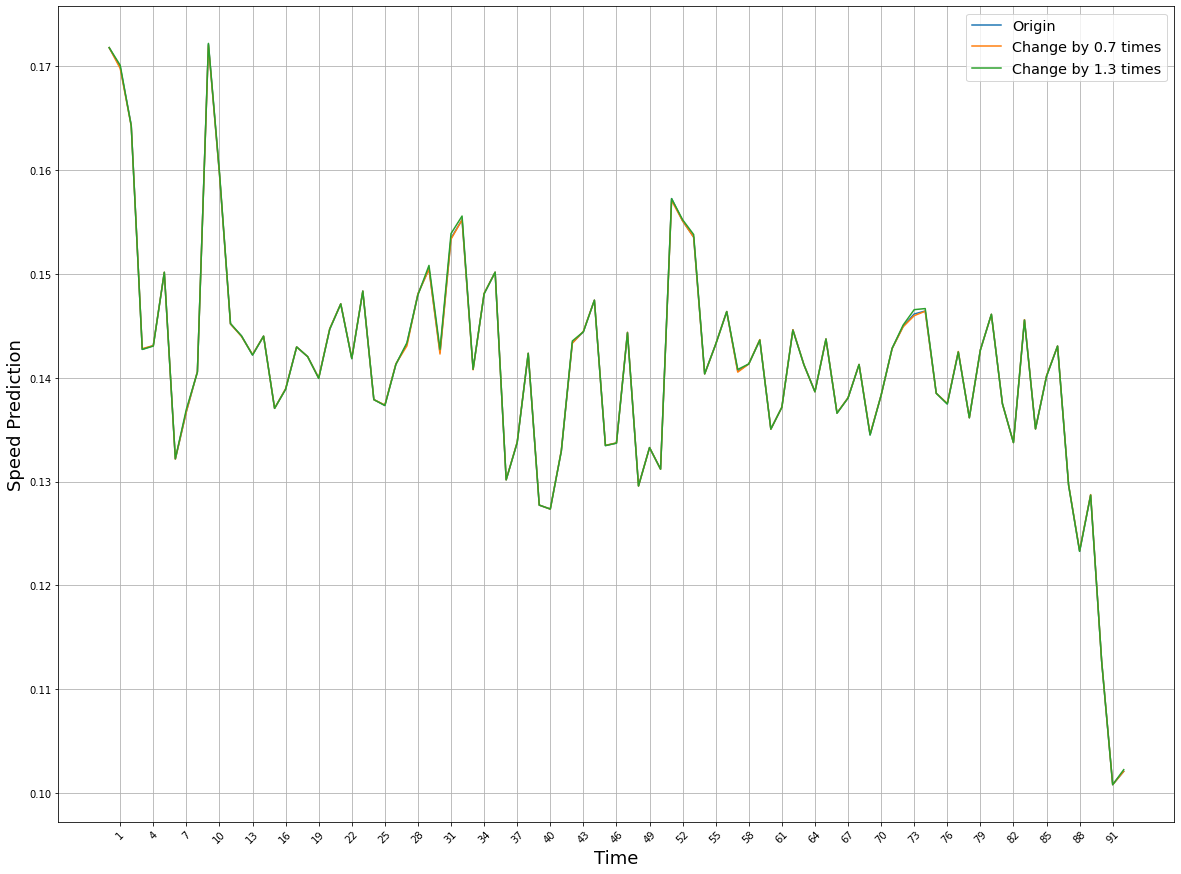

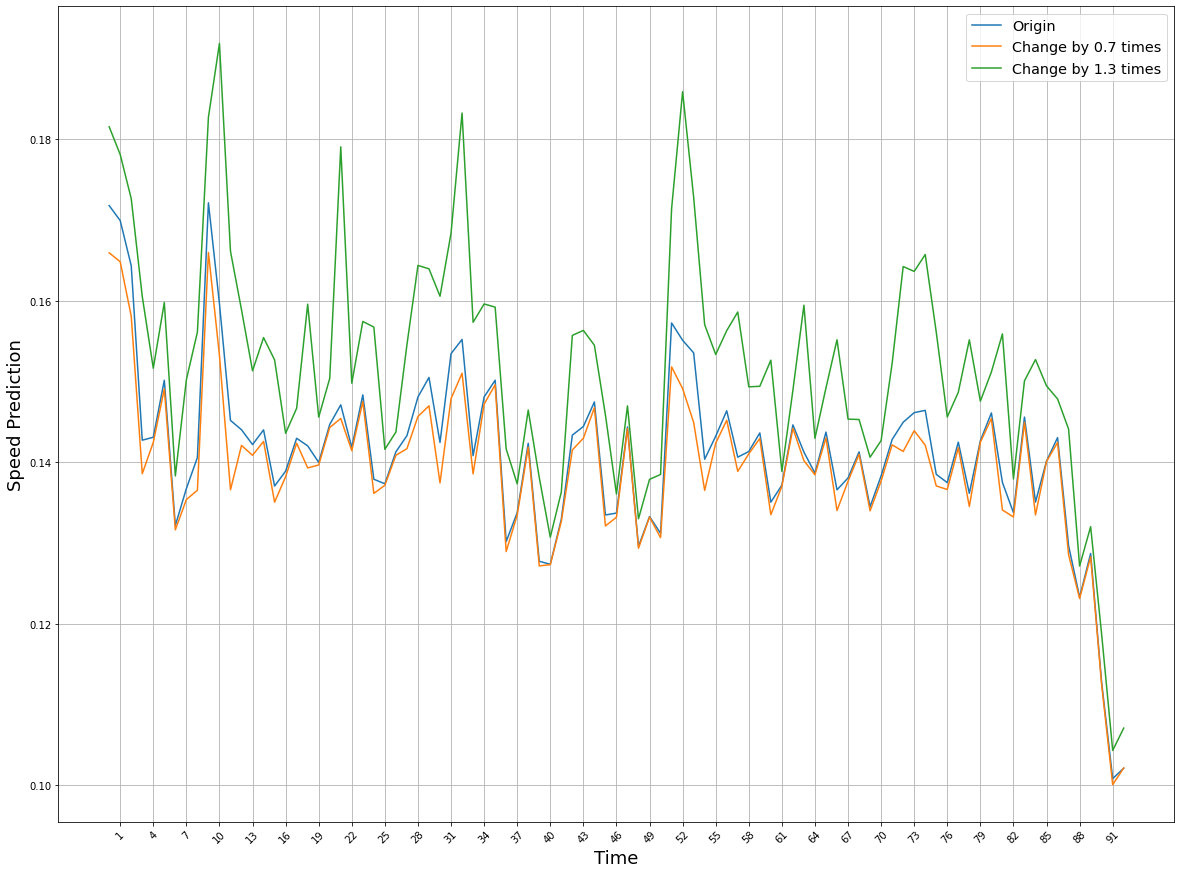

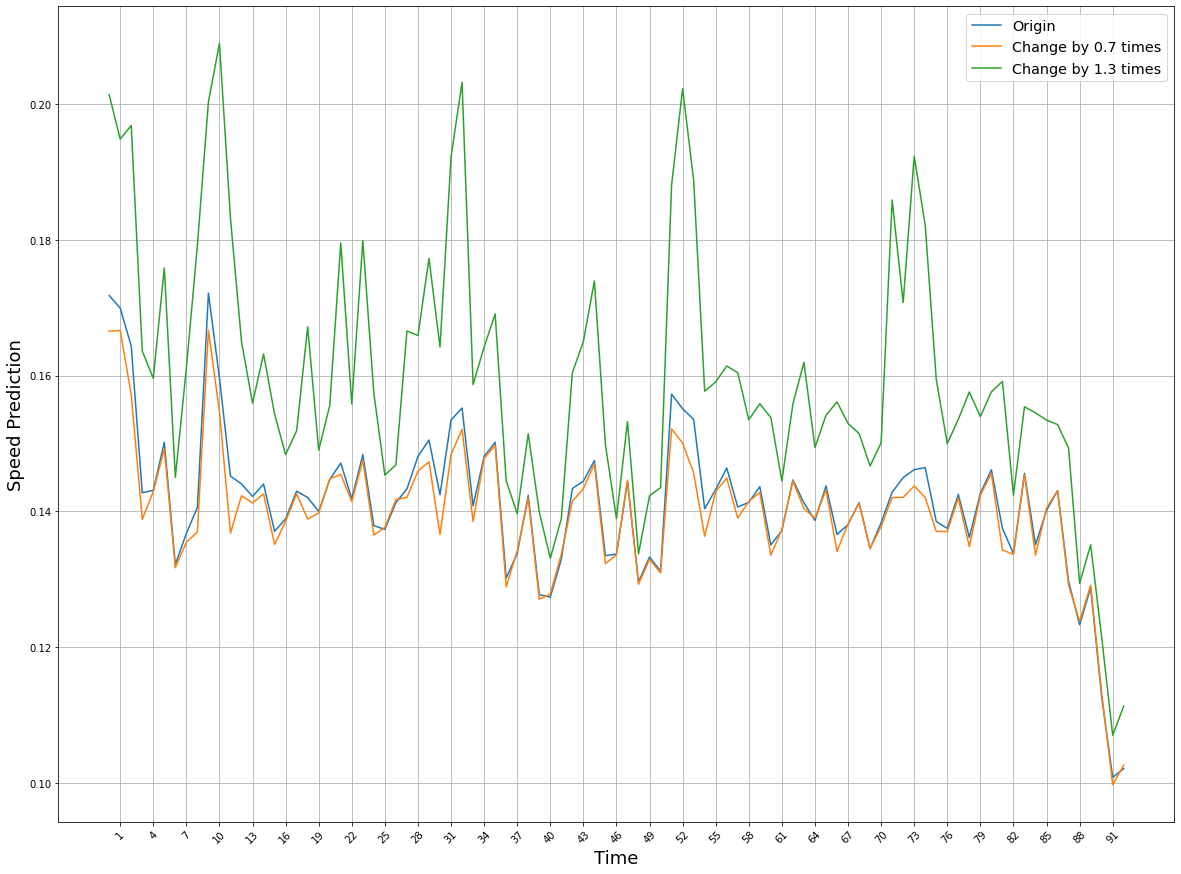

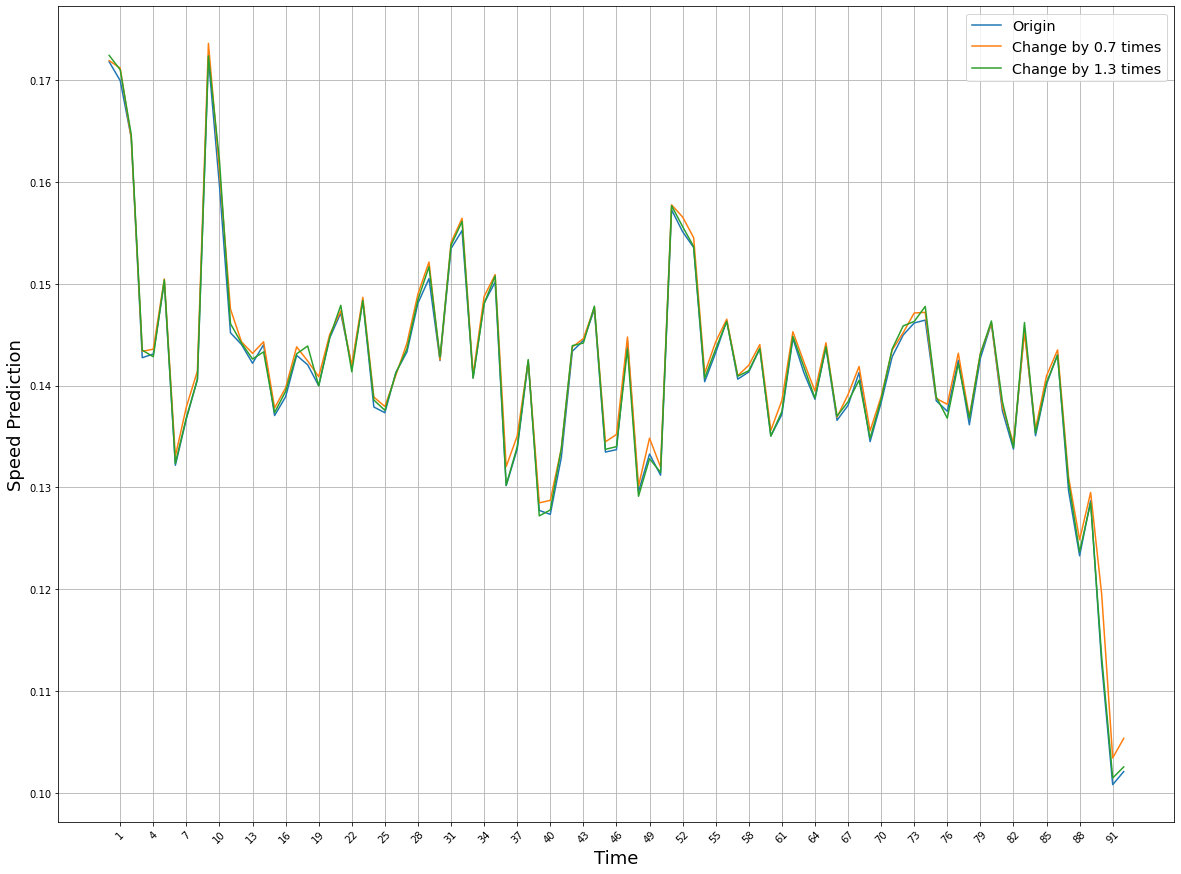

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 
  print('bottom 10')
  day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,10) #Exp 2) Control bottom10



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,2982,3244,2148,3354,397,392,3294,3178,3355]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_rfe_topx'+str(k)+'_'+str(tg)+'.jpg')



def day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]

  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    bottomidx = [395,2087,394,2088,3219,2983,3156,3158,3190,3187]
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      bottomk = bottomidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][bottomk] = changespeed05[t][bottomk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
      
      changespeed15 = newspeed.copy()
      changespeed15[t][bottomk] = changespeed15[t][bottomk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Bottom 10')
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('BOTTOM SIMULATION')
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("change07 Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("change13 Mean :  ",np.mean(np.divide(d2,origin) *100))
    
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('simulate_rfe_bottomx'+str(tg)+'.jpg')    



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

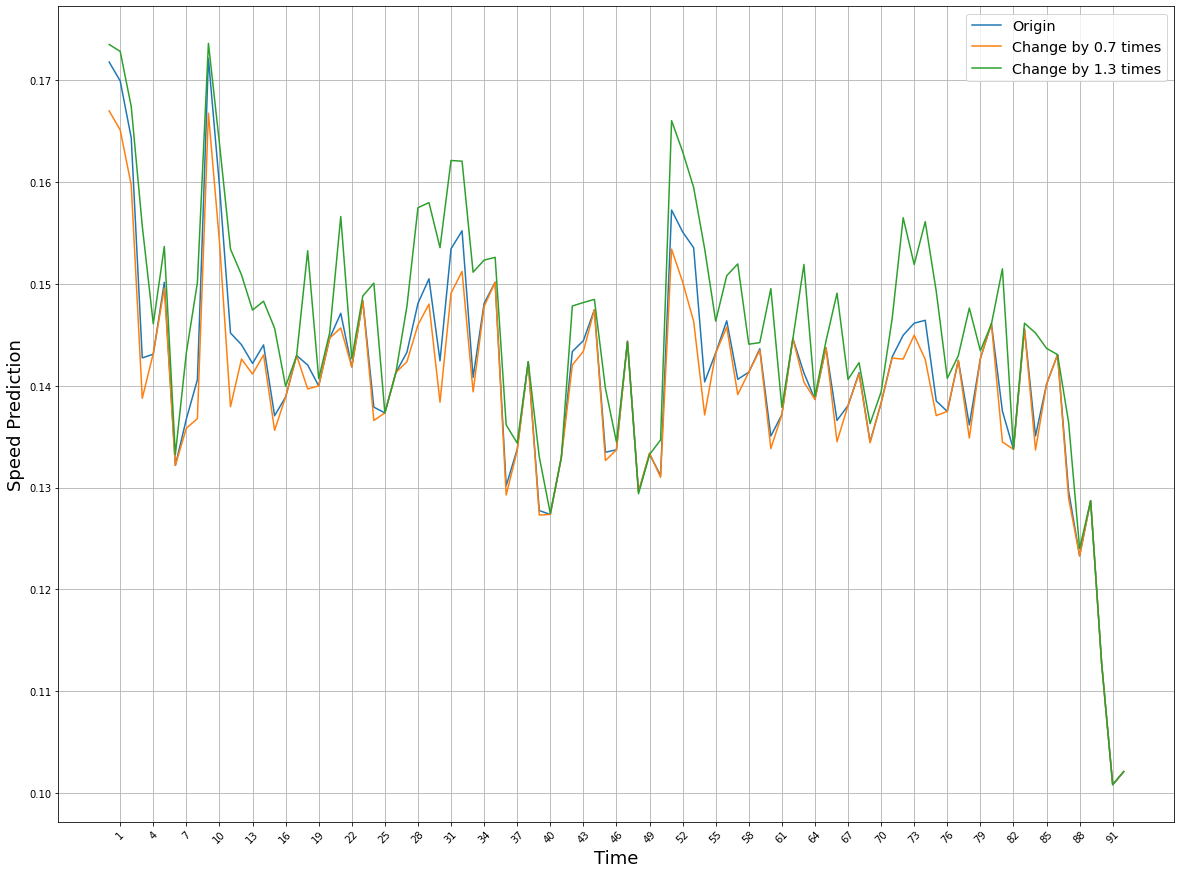

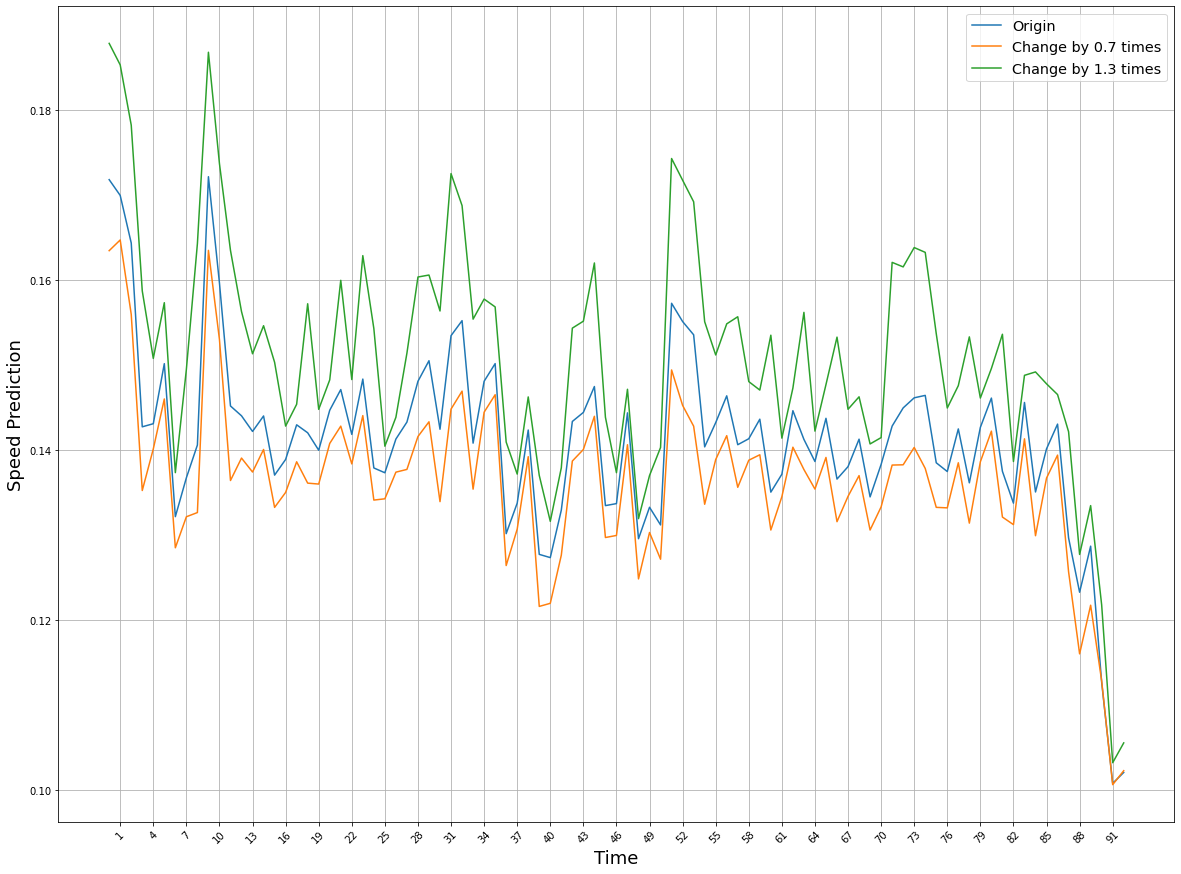

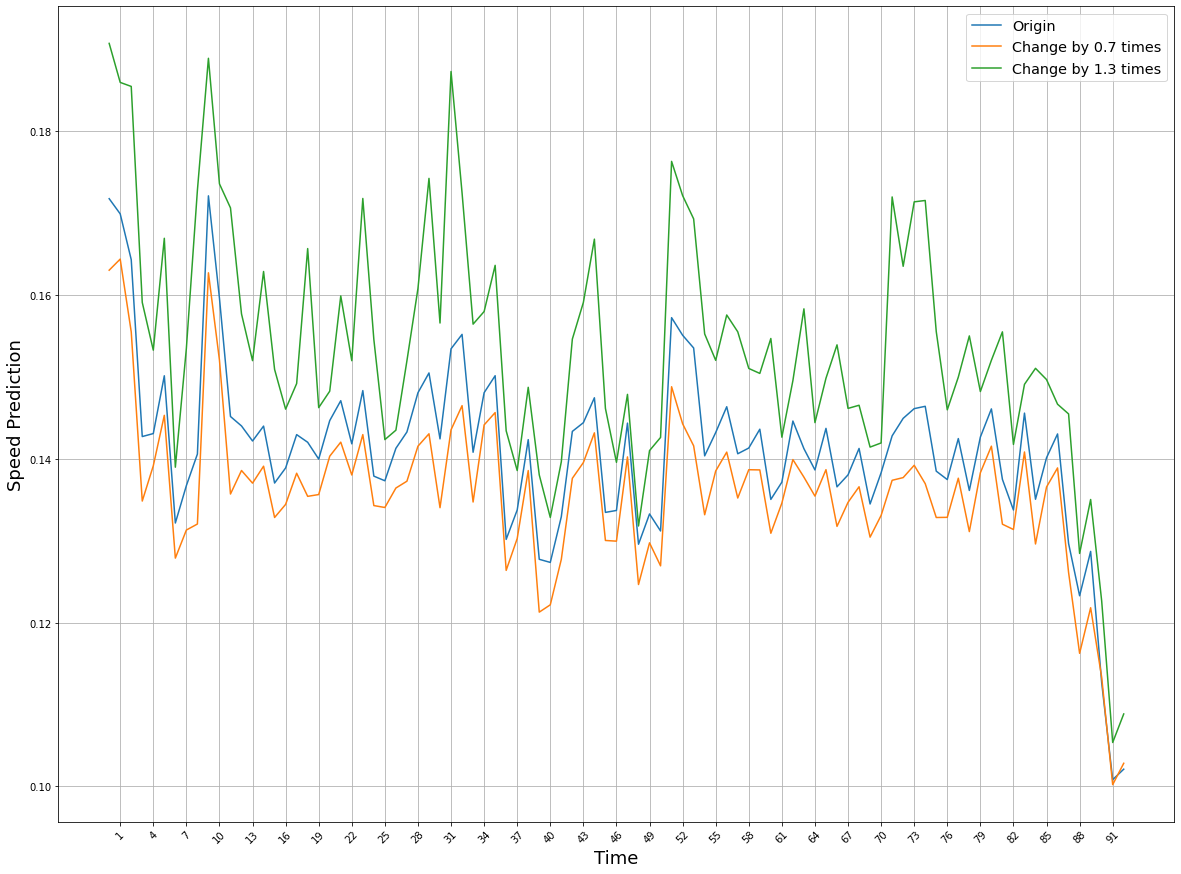

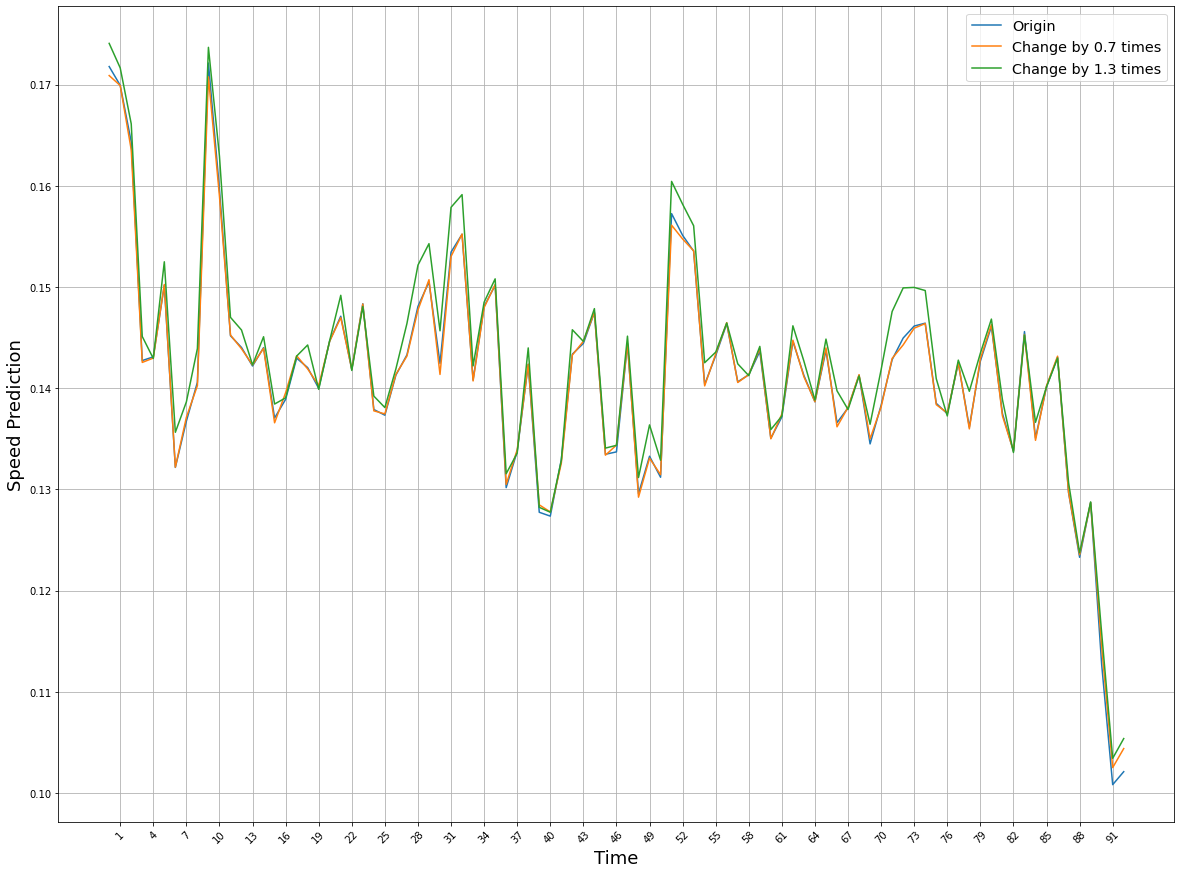

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 
  print('bottom 10')
  day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,10) #Exp 2) Control bottom10



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3354,469,3223,2148,392,2982,394,3353,2970,3244]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_fi_topx'+str(k)+'_'+str(tg)+'.jpg')



def day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]

  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    bottomidx = [3219,3190,4629,2983,3156,3126,3134,3352,3158,3187]
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      bottomk = bottomidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][bottomk] = changespeed05[t][bottomk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
      
      changespeed15 = newspeed.copy()
      changespeed15[t][bottomk] = changespeed15[t][bottomk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Bottom 10')
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('BOTTOM SIMULATION')
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("change07 Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("change13 Mean :  ",np.mean(np.divide(d2,origin) *100))
    
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('simulate_fi_bottomx'+str(tg)+'.jpg')    



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

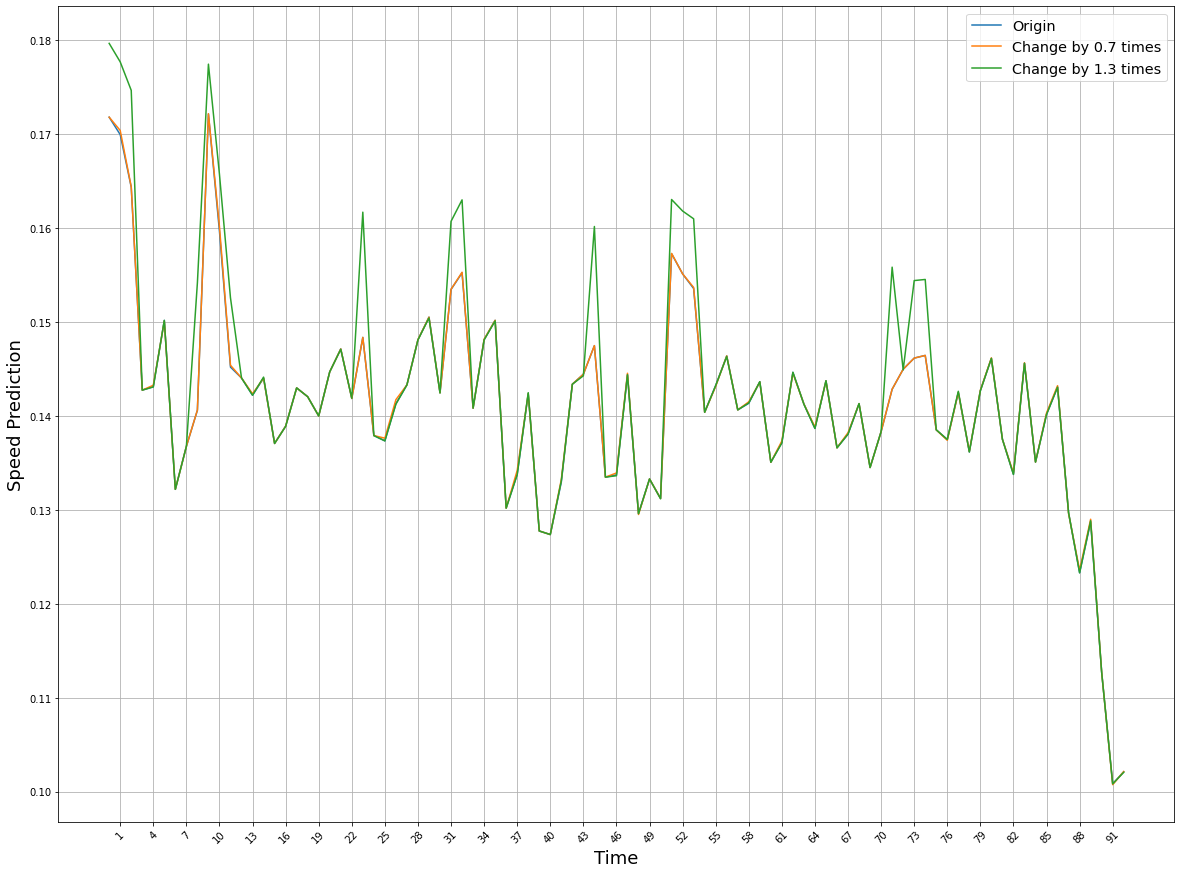

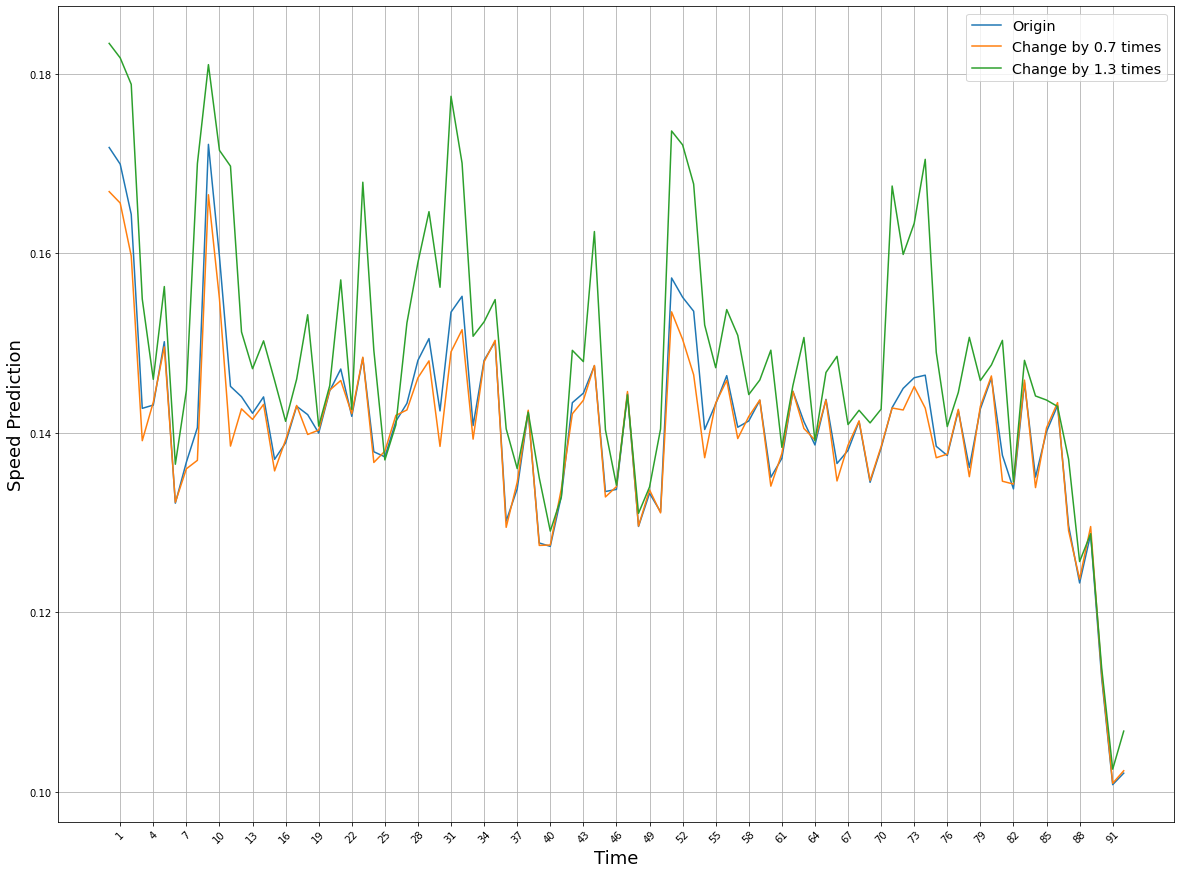

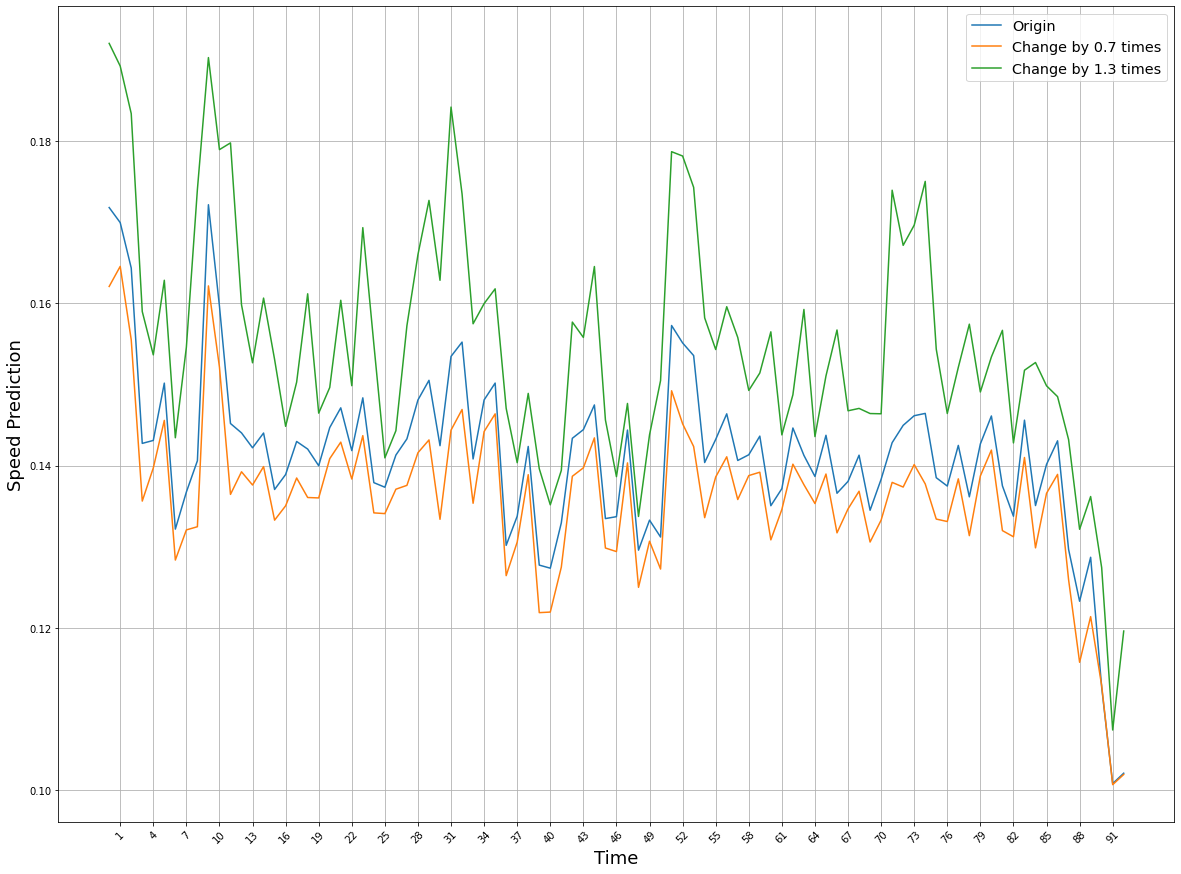

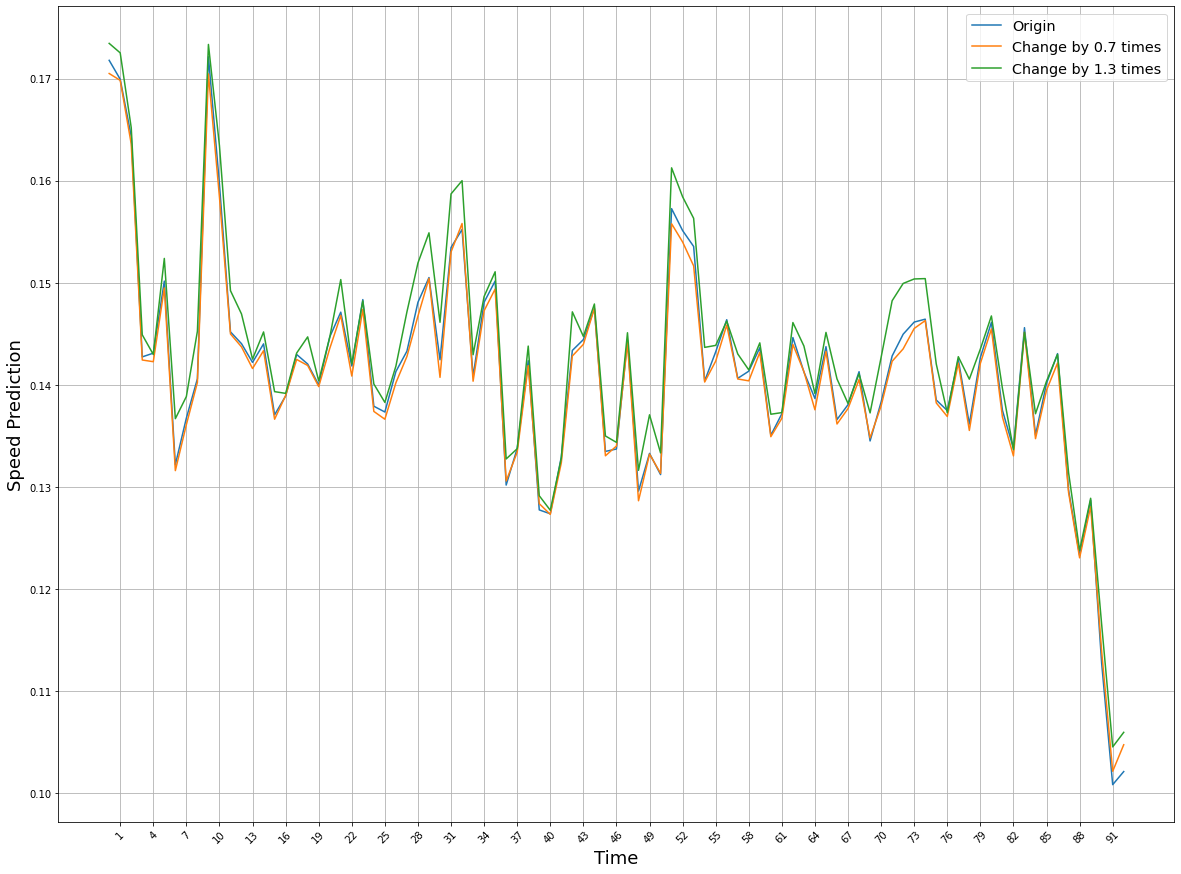

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
  ii = model.predict(input_test_df)
  print(np.shape(ii))
     
  ii = ii*130+0.74
  oo = output_test*130+0.74
      
  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict 
 
  model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 
  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10 
  print('bottom 10')
  day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,10) #Exp 2) Control bottom10



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = xg.XGBRegressor()
    model.load_model("model_sklearn_xgb.json"+scaled+str(tg))
    topidx = [3223,3354,2982,392,2148]
   
    
    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
      
      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())
      
      topk = topidx[0:k]  
      
      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())
  
      #k = bottomidx[0]
      
      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)

   
    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day)) 
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))
    
    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")    
    plt.plot(change15, label = "Change by 1.3 times")    

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top5x'+str(k)+'_'+str(tg)+'.jpg')





hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
[0]	validation_0-rmse:0.33518	validation_1-rmse:0.33388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.33184	validation_1-rmse:0.33056
[2]	validation_0-rmse:0.32854	validation_1-rmse:0.32726
[3]	validation_0-rmse:0.32527	validation_1-rmse:0.32400
[4]	validation_0-rmse:0.32203	validation_1-rmse:0.32078
[5]	validation_0-rmse:0.31883	validation_1-rmse

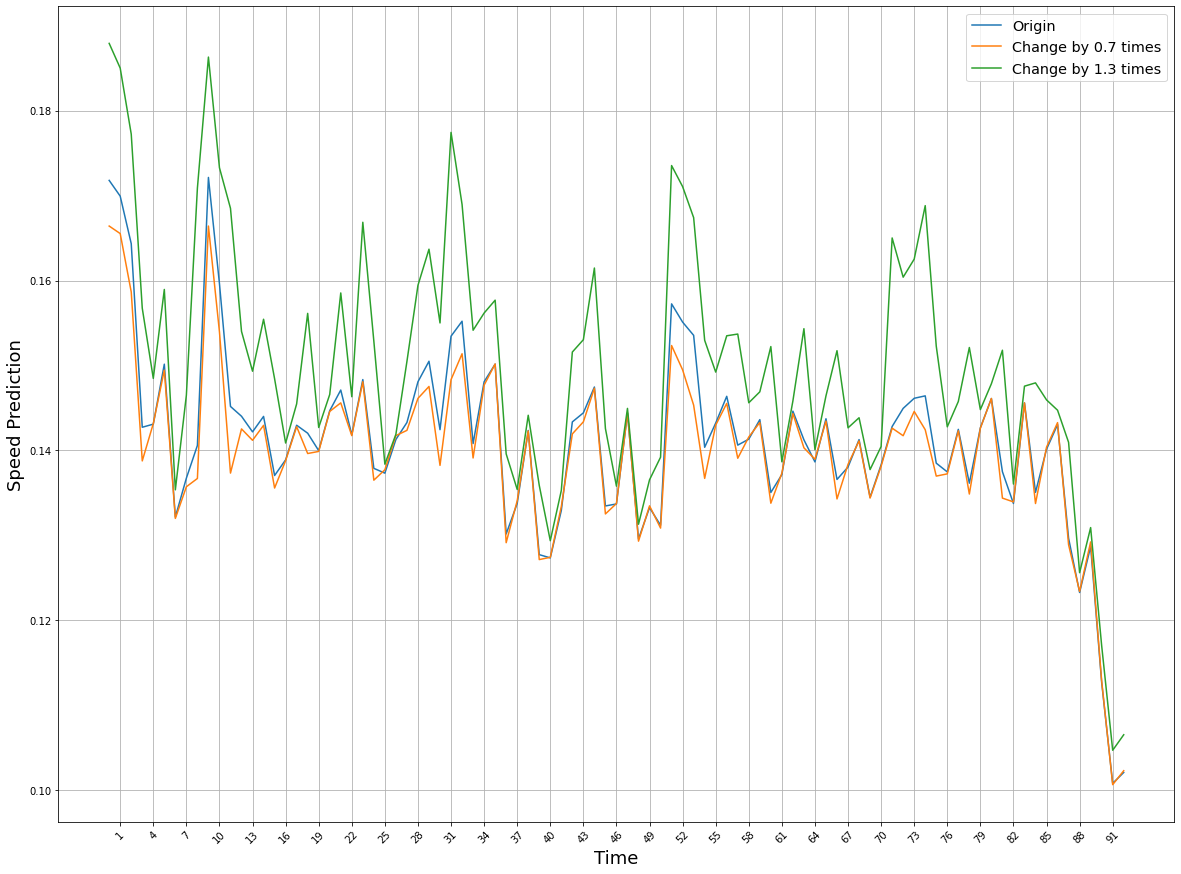

In [ ]:
if __name__=='__main__':    
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠  
 
  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo() 
  
  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0] 
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized
  
  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()  
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641] 
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx)) 
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32') 
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day']) 

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])  
  
  model = xg.XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9)
  model.fit(input_train_df, output_train_df, 
          eval_set=[(input_train_df, output_train_df), (input_test_df, output_test_df)], 
          early_stopping_rounds=20)
        
 
  #model.save_model("model_sklearn_xgb.json"+scaled+str(tg))

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx
  
  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365] 
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist() 
 

  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5 
  



In [ ]:
!pip install lime
import lime

In [ ]:
from lime import lime_tabular

interpretor = lime_tabular.LimeTabularExplainer(
    training_data=np.array(input_train_df),
    feature_names= input_train_df.columns,
  
    mode='regression'
)

In [ ]:
model = xg.XGBRegressor()
model.load_model("model_sklearn_xgb.jsonG4640")

In [ ]:
exp = interpretor.explain_instance(
    data_row = input_test_df.iloc[6], ##new data
    predict_fn = model.predict)
exp.save_to_file('lime_xgb.html')
fig = exp.as_pyplot_figure()